In [1]:
import scanpy as sc
from pathlib import Path

import anndata as ad
import torch
import numpy as np
from popari.model import Popari
from pathlib import Path
from popari.components import PopariDataset
from popari import pl, tl
from popari.model import load_trained_model
from popari.io import save_anndata

from tqdm.auto import trange
import pandas as pd

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning

In [2]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import scipy
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

import scanpy as sc
import anndata as ad

import torch

import mlflow
from mlflow.tracking import MlflowClient

from popari.model import load_trained_model, Popari
from popari.mlflow.util import load_from_mlflow_run
from popari import pl, tl

In [3]:
# Save PDF text as text
matplotlib.rcParams['pdf.fonttype'] = 42

In [4]:
sc._settings.settings._vector_friendly = True

In [ ]:
# ! cp /work/magroup/ehaber/STARmapPlus_preprocessing.ipynb /work/magroup/shahula/spatiotemporal_transcriptomics_integration/Popari/notebooks/starmaplus_preprocessing.ipynb

In [ ]:
! pip install openpyxl

# Load existing STARmap PLUS runs

In [5]:
# Path to location of MLflow runs
relative_path = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/mlflow_experiments/STARmap_plus_eight_replicate/")
absolute_path = relative_path.resolve()

mlflow.set_tracking_uri(absolute_path)

client = MlflowClient(tracking_uri=f"{absolute_path}/mlruns")

# MLflow experiment name (default is '0') and ID of parent run (use MLflow UI to get this)
experiment_id = '0'
best_ids = [
    '51619701000747ebae1bc16ce2fe8d8d', # Using all genes; this has binnning downsample rate of 0.2
    # '1b97e29b77dc4e4f8a508148dd62094f', # Using all genes; this has binnning downsample rate of 0.3
    '66bcc8ecbc684dcf9187c5809d420d1a' # Using all genes; this is paired with the above run
]

domain_segmentation_run = client.get_run(best_ids[0])
function_analysis_run = client.get_run(best_ids[1])

In [6]:
domain_segmentation_run.data.params

{'dataset_path': '../../data/STARmapPlus/eight_replicate_hvgs_None.h5ad',
 'nmf_preiterations': '10',
 'spatial_preiterations': '50',
 'lambda_Sigma_bar': '0.0001',
 'num_iterations': '200',
 'random_state': '0',
 'hierarchical_levels': '2',
 'spatial_affinity_mode': 'differential lookup',
 'K': '20',
 'lambda_Sigma_x_inv': '0.0001',
 'binning_downsample_rate': '0.2'}

In [7]:
function_analysis_run.data.params

{'binning_downsample_rate': '0.2',
 'hierarchical_levels': '3',
 'spatial_preiterations': '50',
 'nmf_preiterations': '10',
 'random_state': '0',
 'K': '20',
 'lambda_Sigma_bar': '0.0001',
 'spatial_affinity_mode': 'differential lookup',
 'num_iterations': '200',
 'lambda_Sigma_x_inv': '0.0001',
 'dataset_path': '../../data/STARmapPlus/eight_replicate_hvgs_None.h5ad'}

## Load unsuperresolved model

In [ ]:
# This block gets all the child runs for the parent and runs postprocessing/analysis code
domain_segmentation_model = load_from_mlflow_run(domain_segmentation_run, client, context=dict(device="cuda:0", dtype=torch.float64), verbose=1)
function_analysis_model = load_from_mlflow_run(function_analysis_run, client, context=dict(device="cuda:0", dtype=torch.float64), verbose=1)

In [ ]:
models = (domain_segmentation_model,)

In [ ]:
for model in models:
    model.set_superresolution_lr(1e-1)
    model.superresolve(n_epochs=10000, tol=1e-6, use_manual_gradients=False, update_spatial_affinities=False)
    

In [ ]:
for model in models:
    model.set_superresolution_lr(1e-2)
    model.superresolve(n_epochs=10000, tol=1e-6, use_manual_gradients=False, update_spatial_affinities=True)    

In [ ]:
import gc

In [ ]:
gc.collect()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import shutil
shutil.rmtree(relative_path / "domain_segmentation_model")
shutil.rmtree(relative_path / "function_analysis_model")

domain_segmentation_model.save_results(relative_path / "domain_segmentation_model")
function_analysis_model.save_results(relative_path / "function_analysis_model")

## Alternatively, load already superresolved models

In [8]:
from popari.model import load_trained_model

domain_segmentation_model = load_trained_model(relative_path / "domain_segmentation_model")

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/utils.py:349: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are

[2024/12/29 23:34:09]	 Initializing MetageneState
[2024/12/29 23:34:09]	 Initializing SpatialAffinityState
[2024/12/29 23:34:09]	 Initializing EmbeddingOptimizer
[2024/12/29 23:34:09]	 Initializing EmbeddingState
[2024/12/29 23:34:10]	 Reloading level 0
[2024/12/29 23:34:11]	 Initializing MetageneState
[2024/12/29 23:34:11]	 Initializing SpatialAffinityState
[2024/12/29 23:34:11]	 Initializing EmbeddingOptimizer
[2024/12/29 23:34:11]	 Initializing EmbeddingState
[2024/12/29 23:34:12]	 Reloading level 1
[2024/12/29 23:34:13]	 Initializing MetageneState
[2024/12/29 23:34:13]	 Initializing SpatialAffinityState
[2024/12/29 23:34:13]	 Initializing EmbeddingOptimizer
[2024/12/29 23:34:13]	 Initializing EmbeddingState


## Clustering to discover spatial domains

In [9]:
figure_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/Popari/notebooks/starmapplus_figures/")
figure_directory.mkdir(exist_ok=True)

In [10]:
domain_level = 1
joint = True
model = domain_segmentation_model

In [11]:
tl.preprocess_embeddings(model, level=domain_level)
tl.cluster_domains(model, level=domain_level)

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/popari/util.py:615: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_cluster = labels[entity]
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/popari/util.py:618: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neighbor_labels = l

## Original block

In [ ]:
def _propagate_labels(trained_model, label_key: str, starting_level=None,  smooth=False):
    """Propagate a label from the most binned layer to the least binned layer.
    
    """

    if starting_level is None:
        starting_level = trained_model.hierarchical_levels-1
        
    for level in range(starting_level, 0, -1):
        view = trained_model.hierarchy[level]
        high_res_view = trained_model.hierarchy[level-1]
        for dataset, high_res_dataset in zip(view.datasets, high_res_view.datasets):
            B = dataset.obsm[f"bin_assignments_{dataset.name}"]
            labels = dataset.obs[label_key]

            high_res_labels = np.array(labels) @ B.astype(int).toarray()
            if smooth:
                high_res_labels = spatially_smooth_feature(high_res_labels, high_res_dataset.obs["adjacency_list"], max_smoothing_rounds=200, smoothing_threshold=0.3)

            high_res_dataset.obs[label_key] = list(high_res_labels)

In [ ]:
_propagate_labels(model, "smoothed_leiden", starting_level=domain_level, smooth=False)

In [ ]:
spatial_domain_high_res_fig, axes = plt.subplots(2, 4, squeeze=False, dpi=600, constrained_layout=False)
_plot_in_situ(model.hierarchy[0].datasets, edges_width=0, color="smoothed_leiden", size=0.75, axes=axes, dpi=600, joint=True, palette="tab20b")

## New block

In [12]:
sc.__version__

'1.9.3'

In [ ]:
# from popari._dataset_utils import _plot_in_situ
spatial_domain_fig, axes = plt.subplots(2, 4, squeeze=False, dpi=600, constrained_layout=False)

for dataset, ax in zip(model.hierarchy[domain_level].datasets, axes.flat):
    # _cluster([dataset], target_clusters=target_clusters, verbose=True, use_rep="smoothed_expression", n_neighbors=40, joint=True)
    smooth_labels(dataset)
    pass

pl.in_situ(model, level=domain_level, edges_width=0, color="smoothed_leiden", size=2, axes=axes, dpi=600, joint=True, marker=",", palette="tab20b")

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/work/magroup/shahu

([AnnData object with n_obs × n_vars = 1298 × 2766
      obs: 'total_transformed_counts', 'leiden', 'batch', 'smoothed_domain'
      uns: 'M', 'Sigma_x_inv', 'adjacency_matrix', 'chunk_1d_density', 'chunk_size', 'leiden_colors', 'losses', 'neighbors', 'pca', 'popari_hyperparameters', 'spatial_affinity_bar', 'spatial_neighbors', 'sigma_yx', 'leiden'
      obsm: 'X', 'X_pca', 'bin_assignments_13mon_contr_repl1_level_1', 'bin_assignments_13mon_contr_repl2_level_1', 'bin_assignments_13mon_dis_repl1_level_1', 'bin_assignments_13mon_dis_repl2_level_1', 'bin_assignments_8mon_contr_repl1_level_1', 'bin_assignments_8mon_contr_repl2_level_1', 'bin_assignments_8mon_dis_repl1_level_1', 'bin_assignments_8mon_dis_repl2_level_1', 'normalized_X', 'spatial', 'adjacency_list', 'smoothed_expression'
      obsp: 'adjacency_matrix', 'distances', 'connectivities',
  AnnData object with n_obs × n_vars = 1419 × 2766
      obs: 'total_transformed_counts', 'leiden', 'batch', 'smoothed_domain'
      uns: 'M', 'S

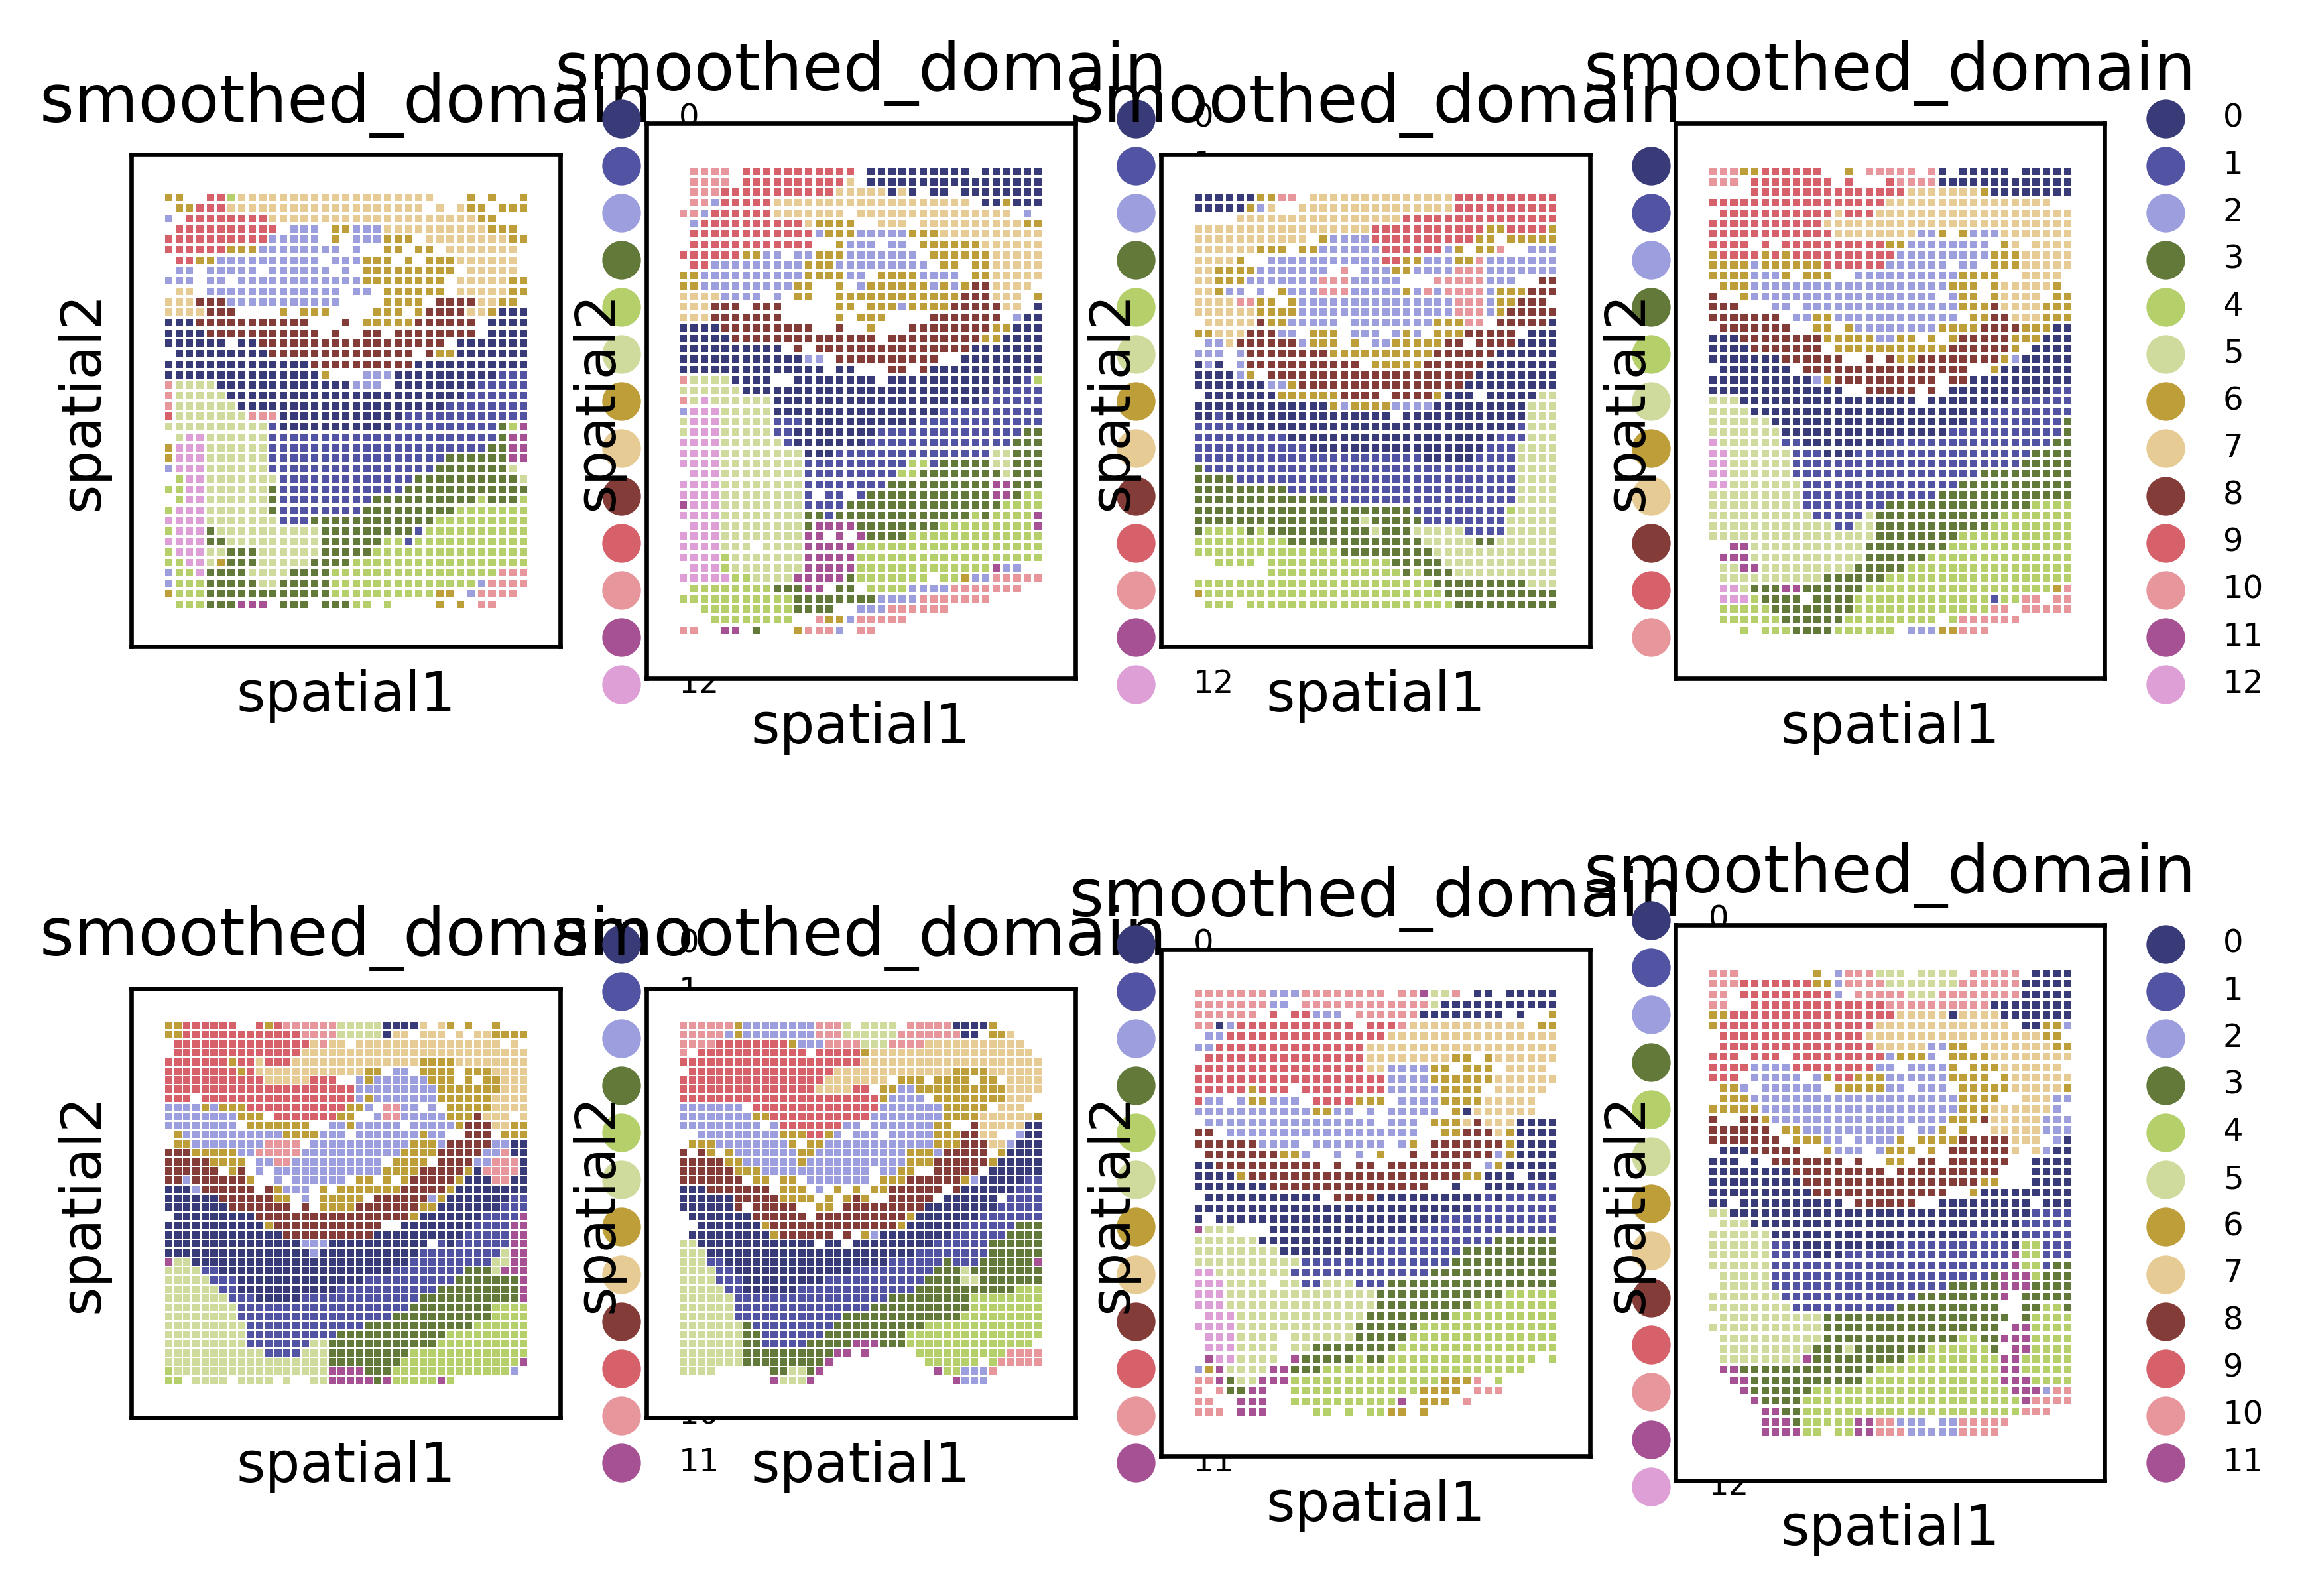

In [16]:
spatial_domain_fig, axes = plt.subplots(2, 4, squeeze=False, dpi=600, constrained_layout=False)
pl.in_situ(model, level=domain_level, edges_width=0, color="smoothed_domain", size=2, axes=axes, dpi=600, joint=True, marker=",", palette="tab20b")

In [30]:
tl.propagate_labels(model, "smoothed_domain")

/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/magroup/shahula/bin/miniconda3/envs/popari_distribution/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  uti

([AnnData object with n_obs × n_vars = 8186 × 2766
      obs: 'batch', 'n_counts', 'leiden', 'smoothed_domain'
      uns: 'M', 'Sigma_x_inv', 'adjacency_matrix', 'leiden_colors', 'losses', 'neighbors', 'popari_hyperparameters', 'spatial_affinity_bar', 'spatial_neighbors', 'sigma_yx'
      obsm: 'X', 'normalized_X', 'spatial', 'adjacency_list'
      obsp: 'adjacency_matrix',
  AnnData object with n_obs × n_vars = 8202 × 2766
      obs: 'batch', 'n_counts', 'leiden', 'smoothed_domain'
      uns: 'M', 'Sigma_x_inv', 'adjacency_matrix', 'leiden_colors', 'losses', 'neighbors', 'popari_hyperparameters', 'spatial_affinity_bar', 'spatial_neighbors', 'sigma_yx'
      obsm: 'X', 'normalized_X', 'spatial', 'adjacency_list'
      obsp: 'adjacency_matrix',
  AnnData object with n_obs × n_vars = 8506 × 2766
      obs: 'batch', 'n_counts', 'leiden', 'smoothed_domain'
      uns: 'M', 'Sigma_x_inv', 'adjacency_matrix', 'leiden_colors', 'losses', 'neighbors', 'popari_hyperparameters', 'spatial_affinity_

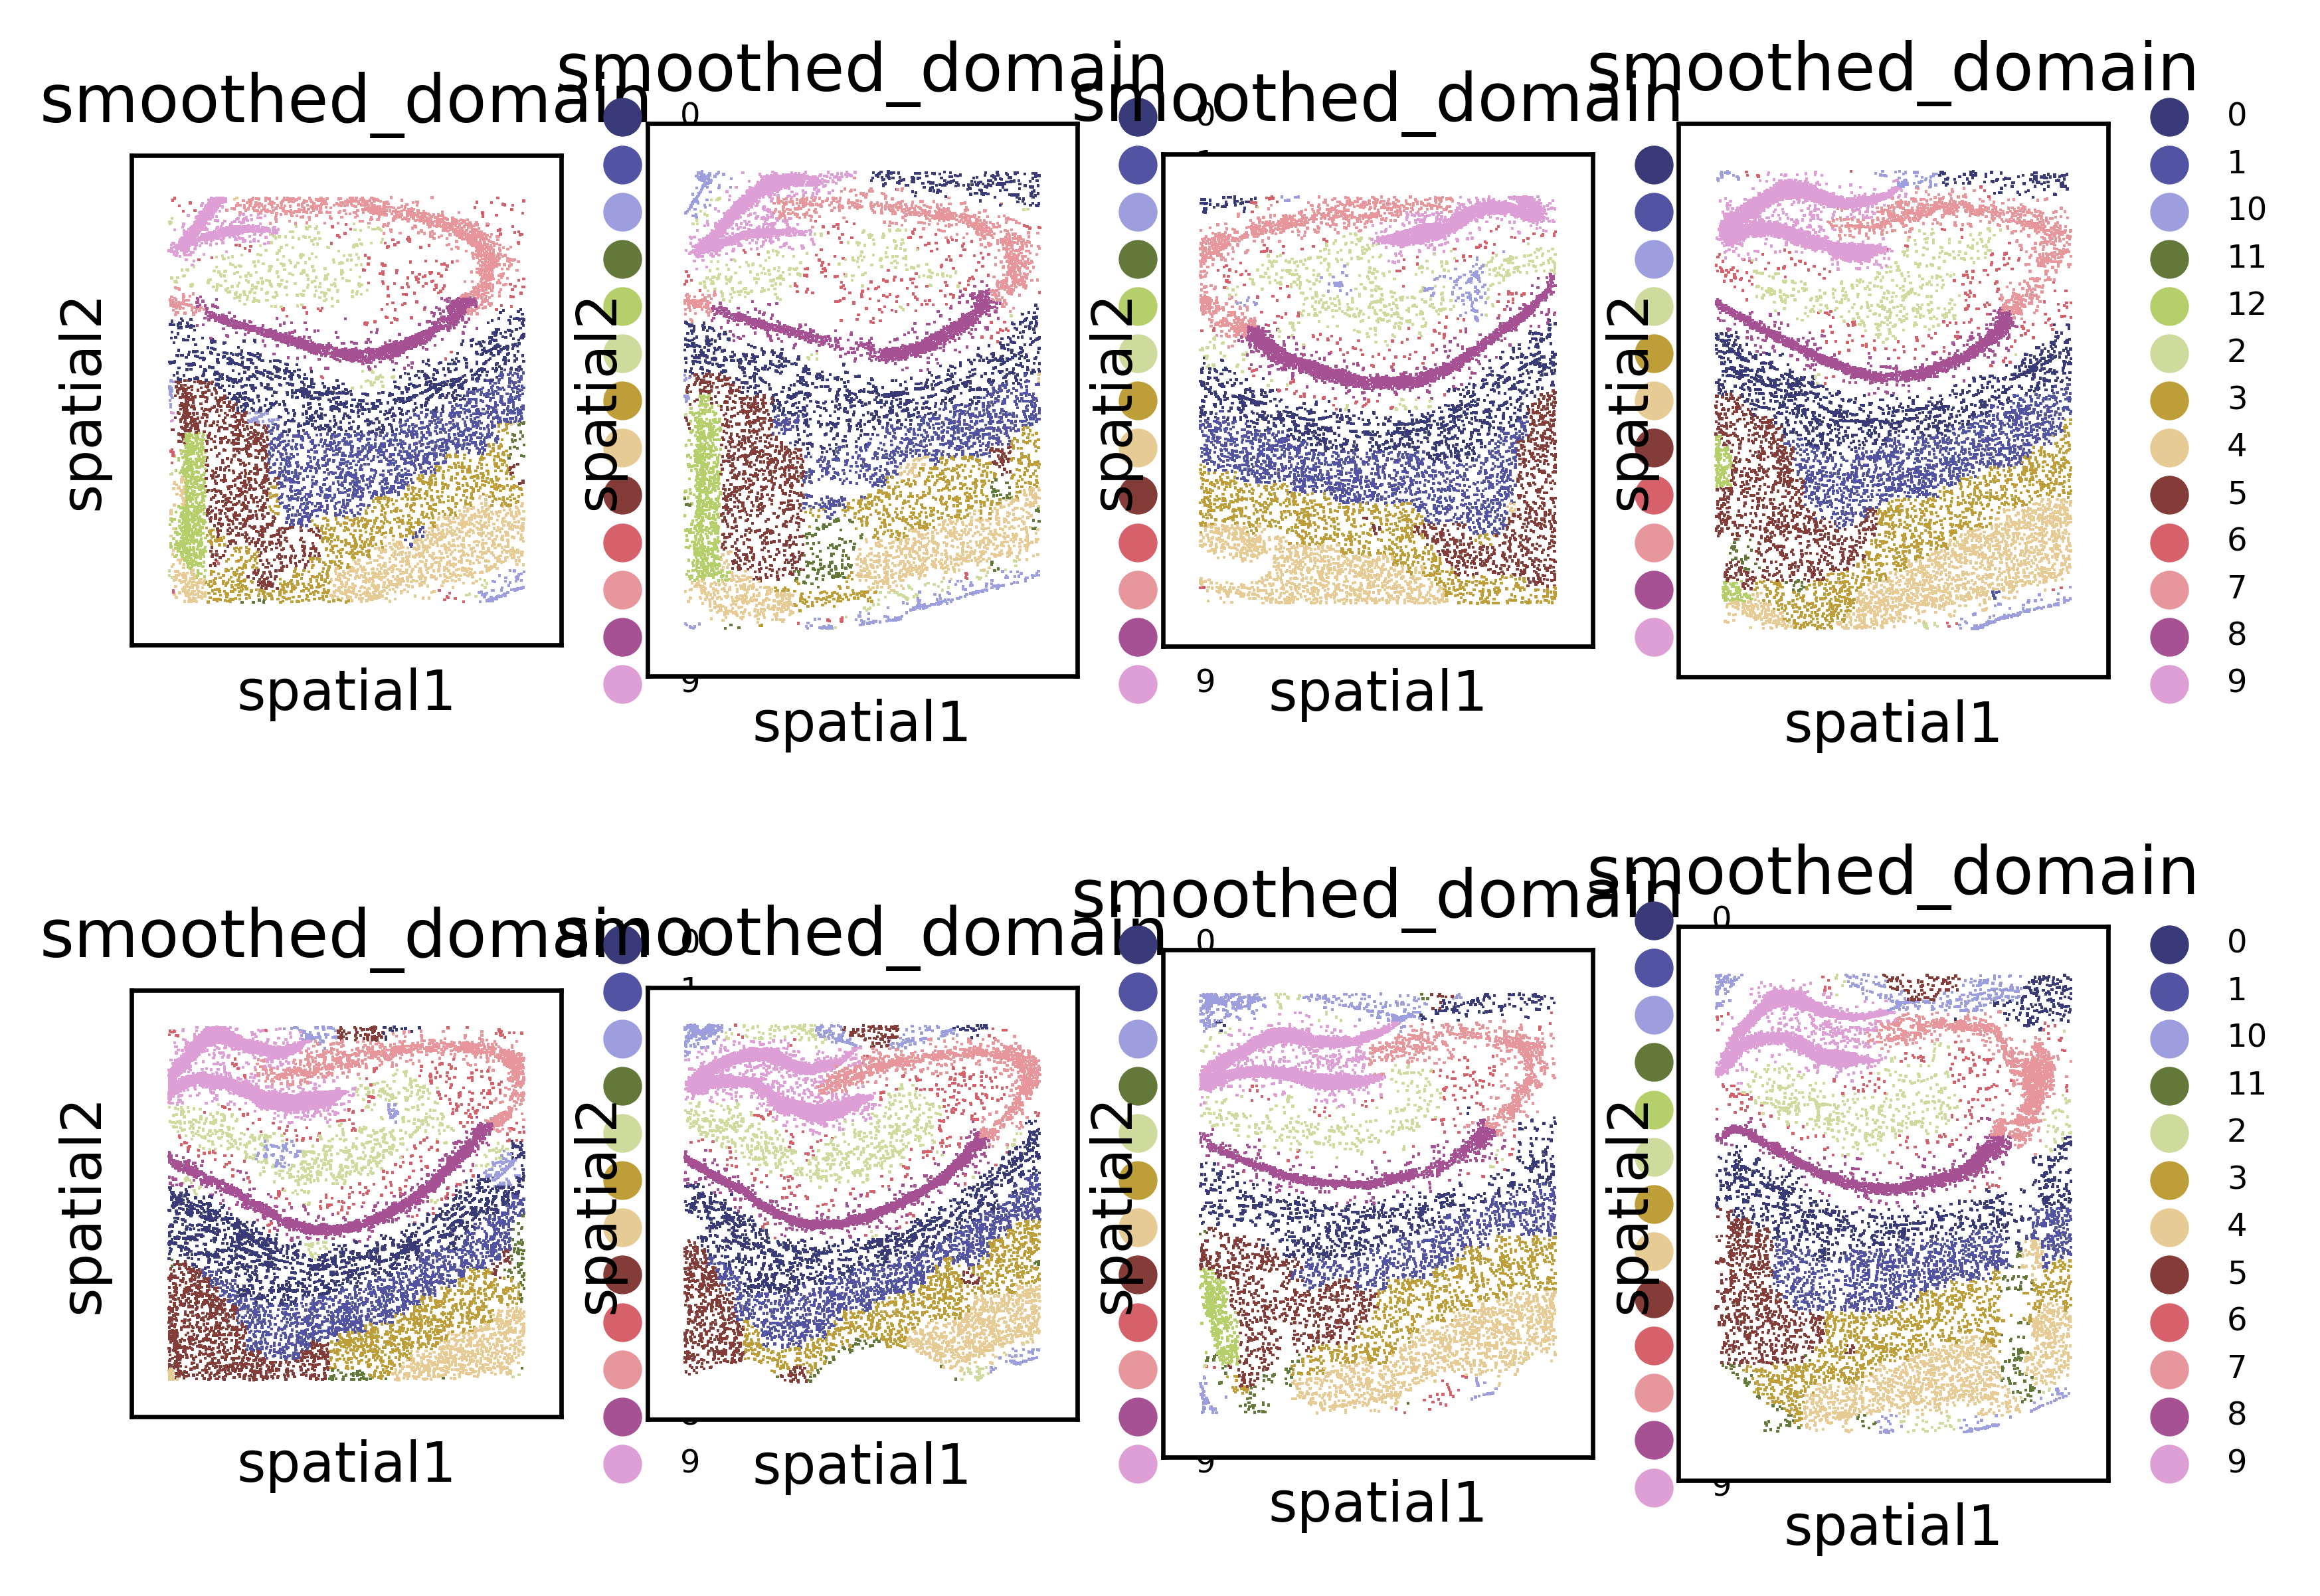

In [31]:
spatial_domain_fig, axes = plt.subplots(2, 4, squeeze=False, dpi=600, constrained_layout=False)
pl.in_situ(model, level=0, edges_width=0, color="smoothed_domain", size=2, axes=axes, dpi=600, joint=True, marker=",", palette="tab20b")

In [32]:
model = domain_segmentation_model

In [ ]:
# Reload gene expressions
from popari.io import load_anndata

hvgs=None

output_directory = Path(f'/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/STARmapPlus/')
raw_datasets, replicate_names = load_anndata(output_directory / f"eight_replicate_hvgs_{hvgs}.h5ad")
for dataset, raw_dataset in zip(model.hierarchy[0].datasets, raw_datasets):
    dataset.X = raw_dataset.X.copy()
    dataset.obs.index = pd.Index(np.arange(len(dataset))).astype(str)

In [ ]:
from typing import Sequence, Optional

# Draw top gene expression matrix
from scipy.stats import zscore
from matplotlib.ticker import FixedLocator

def plot_region_marker_genes(datasets, region_key="brain_domain", per_dataset: bool = False, num_marker_genes: int = 10, ordering: Optional[Sequence[str]] = None):
    """
    """
    num_datasets = len(datasets)

    # 2/0
    
    merged_dataset = ad.concat(datasets, join="outer", keys=[dataset.name for dataset in datasets], label="dummy", merge="unique", uns_merge="unique", pairwise=True)
    
    unique_regions = sorted(merged_dataset.obs[region_key].unique())

    if ordering is not None:
        assert sorted(unique_regions) == sorted(ordering), "Ordering must contain exactly the regions that are present in the datasets." 

        unique_regions = ordering
        
    num_regions = len(unique_regions)

    gene_names = np.array(merged_dataset.var.index)
    _, num_genes = merged_dataset.shape
    region_specific_means = np.zeros((num_regions, num_genes))
    region_and_dataset_specific_means = np.zeros((num_regions * num_datasets, num_genes))
    
    for region_index, region in enumerate(unique_regions):
        region_subset = merged_dataset[merged_dataset.obs[region_key] == region]
        region_specific_means[region_index] = region_subset.X.mean(axis=0)

        for dataset_index, dataset in enumerate(datasets):
            region_subset = dataset[dataset.obs[region_key] == region]
            region_and_dataset_specific_means[region_index * num_datasets + dataset_index] = region_subset.X.mean(axis=0)
            
    region_specific_zscores = zscore(region_specific_means, axis=0)
    region_and_dataset_specific_zscores = zscore(np.nan_to_num(region_and_dataset_specific_means), axis=0)

    marker_gene_indices = np.argsort(region_specific_zscores, axis=1)[:, -num_marker_genes:][:, ::-1]
    marker_genes = gene_names[marker_gene_indices]

    final_zscores = region_specific_zscores[:, marker_gene_indices].reshape((-1, num_marker_genes * num_regions)).T
    final_dataset_specific_zscores = region_and_dataset_specific_zscores[:, marker_gene_indices].reshape((-1, num_marker_genes * num_regions)).T


    if per_dataset:
        aspect_multiplier = num_datasets
        image = final_dataset_specific_zscores
    else:
        aspect_multiplier = 1
        image = final_zscores
    
    vmax = np.max(np.abs(image))
    fig, ax = plt.subplots(dpi=600)
    
    im = ax.imshow(image, cmap='bwr', vmax=vmax, vmin=-vmax, aspect = aspect_multiplier / num_marker_genes, interpolation='nearest')

    plt.colorbar(im, ax=ax)
    
    ax.tick_params(axis='y', which='major', length=0)
    ax.tick_params(axis='y', which='minor', length=15)

    widths = np.full(num_regions, num_marker_genes)
    bounds = np.insert(widths, 0, 0).cumsum() - 0.5
    ticks_pos = (bounds[:-1] + bounds[1:]) / 2 

    stringified_marker_genes = [f"{region_name} - {', '.join(gene_set)}" for region_name, gene_set in zip(unique_regions, marker_genes)]
    major_ticks_pos = np.arange(num_regions) * num_marker_genes + (num_marker_genes / 2)
    ax.set_yticks(major_ticks_pos, stringified_marker_genes)
    ax.yaxis.set_minor_locator(FixedLocator(bounds))

    widths = np.full(num_regions, aspect_multiplier)
    bounds = np.insert(widths, 0, 0).cumsum() - 0.5
    ax.set_xticks([])
    ax.xaxis.set_minor_locator(FixedLocator(bounds))

    return fig, marker_genes

In [ ]:
label_mapping = {
    '11': 'L? (other excitatory) / 11',
    '0': 'WM / 0',
    '2': 'CAslmB / 2',
    '6': 'CAslmA / 6',
    '5': 'RSP B / 5',
    '3': 'L5 / 3',
    '12': 'RSP A / 12',
    '10': 'Meninges / 10',
    '4': 'L2/3/4 / 4',
    '1': 'L6 / 1',
    '8': 'CA1 / 8',
    '7': 'CA2/3 / 7',
    '9': 'DG / 9',
}

In [ ]:
# Map labels if possible
for dataset in model.hierarchy[0].datasets:
    cluster_labels = dataset.obs["smoothed_leiden"]
    domain_labels = [label_mapping.get(cluster_label, cluster_label) for cluster_label in cluster_labels]
    dataset.obs["brain_domain"] = domain_labels

In [ ]:
ordering = ['Meninges / 10', 'L2/3/4 / 4', 'L5 / 3', 'L6 / 1', 'L? (other excitatory) / 11', 'RSP A / 12', 'RSP B / 5', 'WM / 0', 'CA1 / 8', 'CA2/3 / 7', 'DG / 9', 'CAslmA / 6', 'CAslmB / 2']

In [ ]:
region_marker_genes_fig, region_marker_genes = plot_region_marker_genes(model.hierarchy[0].datasets, ordering=ordering)

In [ ]:
region_dataset_specific_marker_genes_fig, region_marker_genes = plot_region_marker_genes(model.hierarchy[0].datasets, per_dataset=True, num_marker_genes=10, ordering=ordering)

In [ ]:
region_marker_genes_fig.savefig(figure_directory / "region_marker_genes.pdf")

In [ ]:
spatial_domain_fig.savefig(figure_directory/f"spatial_domain_fig.pdf", transparent=True)
spatial_domain_high_res_fig.savefig(figure_directory/f"spatial_domain_high_res_fig.pdf", transparent=True)

In [ ]:
# TODO: enable joint mode
def _hierarchical_cluster(dataset, ax=None, embedding_key: str = "normalized_X", joint=False, label_key: str = "leiden", **dotplot_kwargs):
    """Apply hierarchical clustering and plot using marker gene mapping.
    
    Args:
        
    
    """
    
    X = dataset.obsm[embedding_key]
    num_spots, K = X.shape
    
    mock_dataset = ad.AnnData(
        X=dataset.obsm[embedding_key],
        # obsm=dataset.obsm,
    )

    mock_dataset.var_names=[f"m{index}" for index in range(K)]

    swap_axes = True if "swap_axes" not in dotplot_kwargs else dotplot_kwargs.pop("swap_axes")
    standard_scale = 'var' if "standard_scale" not in dotplot_kwargs else dotplot_kwargs.pop("standard_scale")
    
    mock_dataset.obs = dataset.obs.copy()
#     sc.tl.dendrogram(mock_dataset, groupby=label_key, use_rep=embedding_key)

    fig = sc.pl.dotplot(
        mock_dataset,
        mock_dataset.var_names,
        groupby=label_key,
        dendrogram=False,
        ax=ax,
        standard_scale=standard_scale,
        swap_axes=swap_axes, return_fig=True,
        **dotplot_kwargs
    )
    
#     fig.add_totals()
    fig.show()
    
    return fig

In [ ]:
# cluster_correspondence_fig = _hierarchical_cluster(function_analysis_model.hierarchy[2].datasets[0], label_key="smoothed_leiden", title="Metagene-to-Cluster Correspondence")

In [ ]:
cluster_correspondence_fig = _hierarchical_cluster(model.hierarchy[1].datasets[0], label_key="smoothed_leiden", title="Metagene-to-Cluster Correspondence")

In [ ]:
_ = cluster_correspondence_fig.savefig(figure_directory / "cluster_to_metagene_correspondence.pdf")

## Automatic spatial trends discovered by Popari

In [ ]:
timepoint_values = [8, 13]

In [ ]:
from typing import Sequence
from scipy.stats import pearsonr
from matplotlib import cm
def _normalized_affinity_trends(datasets,
                                K,
                           timepoint_values: Sequence[float],                                   
                           time_unit = "Days",                                                  
                           normalize: bool = False,                                             
                           spatial_affinity_key: str = "Sigma_x_inv",
                           x_scale: str = "normal",
                           n_best: int = 5,                                                     
                           highlight_metric: str = "pearson",                                   
                           figsize: tuple = None,                                               
                           margin_size: float = 0.25,                                           
                           level=0):                                                            
    """Plot trends for every pair of affinities; highlight top trends.                          
                                                                                                
    Args:                                                                                       
        trained_model: the trained Popari model.                                                
        timepoint_values: x-values against which to plot trends                                 
        time_unit: unit in which time is measured (used for x-axis label)                       
    """                                                                                         
                                                                                                
                                                                                                                                         
    all_affinities = np.array([dataset.uns[spatial_affinity_key][dataset.name] for dataset in datasets])
                                                                                                
    if normalize:                                                                               
        for index in range(len(datasets), axes.size):                                           
            prenormalization_affinity_std = np.std(all_affinities, axis=0, keepdims=True)       
            prenormalization_timepoint_std = np.std(timepoint_values)                           
            all_affinities /= prenormalization_affinity_std                                     
            timepoint_values /= prenormalization_timepoint_std

    if x_scale == "log":
        timepoint_values = np.log(timepoint_values)
        
    timepoint_min = np.min(timepoint_values)                                                    
    timepoint_ptp = np.ptp(timepoint_values)                                                    
    timepoint_std = np.std(timepoint_values)                                                    
                                                                                                
    affinity_min = np.min(all_affinities)                                                       
    affinity_ptp = np.ptp(all_affinities)                                                       
    affinity_std = np.std(all_affinities, axis=0, keepdims=True)                                
                                                                                                
                                                                                                
    pearson_correlations = {}                                                                   
    variances = {}                                                                              
    pearson_p_values = {}                                                                       
    slopes = {}                                                                                 
                                                                                                
    for i in range(K):                                                            
        for j in range(i+1):                                                                    
            affinity_values = all_affinities[:, i, j]                                           
            r, p_value = pearsonr(affinity_values, timepoint_values)                            
            variances[(i, j)] = np.var(affinity_values)                                         
            pearson_correlations[(i, j)] = r                                                    
            pearson_p_values[(i, j)] = r                                                        
            slopes[(i, j)] = r * affinity_std[0, i, j] / timepoint_std                          
                                                                                                
    if highlight_metric == "pearson":                                                           
        pairs, metric_values = zip(*pearson_correlations.items())                               
    elif highlight_metric == "variance":                                                        
        pairs, metric_values = zip(*variances.items())                                          
                                                                                                
    pairs = np.array(pairs)                                                                     
    sorted_values = np.argsort(metric_values)                                                   
    best_values = sorted_values[-n_best:][::-1] if n_best > 0 else sorted_values[:-n_best]      
                                                                                                
    top_pairs = pairs[best_values].tolist()                                                     
                                                                                                
    for dataset in datasets:                                                                    
        dataset.uns["spatial_trends"] = {                                                       
            "top_pairs": top_pairs,                                                             
            "pearson_correlations": pearson_correlations,                                       
            "variances": variances,                                                             
            "slopes": slopes                                                                    
        }          

    return top_pairs, pearson_correlations, variances

In [ ]:
from typing import Sequence, Optional
def _plot_normalized_affinity_trends(datasets,
                                     K,                                                      
                                     timepoint_values: Sequence[float],         
                                     timepoint_labels: Optional[Sequence[str]] = None,   
                                     time_unit = "Days",                                                     
                                     normalize: bool = False,                                                
                                     spatial_affinity_key: str = "Sigma_x_inv",
                                     x_scale: str = "normal",
                                     n_best: int = 5,                                                        
                                     highlight_metric: str = "pearson",
                                        
                                     figsize: tuple = None,                                                  
                                     margin_size: float = 0.25,
                                     plot_background_lines: bool = False,
                                     level=0):                                                               
    """Plot trends for every pair of affinities; highlight top trends.                             
                                                                                                   
    Args:                                                                                          
        trained_model: the trained Popari model.                                                   
        timepoint_values: x-values against which to plot trends                                    
        time_unit: unit in which time is measured (used for x-axis label)                          
    """                                                                                            
                                                                                                   
                                                                                                                                          
                                                                                                   
    first_dataset = datasets[0]                                                                    
    spatial_trends = first_dataset.uns["spatial_trends"]                                           
                                                                                                   
    all_affinities = np.array([dataset.uns[spatial_affinity_key][dataset.name] for dataset in datasets])
                                                                                                   
    if normalize:                                                                                  
        for index in range(len(datasets), axes.size):                                              
            axes.flat[index].axis('off')                                                           
            prenormalization_affinity_std = np.std(all_affinities, axis=0, keepdims=True)          
            prenormalization_timepoint_std = np.std(timepoint_values)                              
            all_affinities /= prenormalization_affinity_std                                        
            timepoint_values /= prenormalization_timepoint_std     
    
    timepoint_min = np.min(timepoint_values)                                                       
    timepoint_ptp = np.ptp(timepoint_values)                                                       
    timepoint_std = np.std(timepoint_values)                                                       
                                                                                                   
    affinity_min = np.min(all_affinities)                                                          
    affinity_ptp = np.ptp(all_affinities)                                                          
    affinity_std = np.std(all_affinities, axis=0, keepdims=True)                                   
                                                                                                   
    if figsize is None:                                                                            
        figsize = (10, 5)                                                                          
                                                                                                   
    fig, ax = plt.subplots(dpi=300, figsize=figsize)                                               
                                                                                                   
    ax.set_ylim([affinity_min - margin_size, affinity_min + affinity_ptp + margin_size])           
    ax.set_xlim([timepoint_min - margin_size, timepoint_min + timepoint_ptp + margin_size])        
    ax.set_xticks(timepoint_values)
    if timepoint_labels is None:
        timepoint_labels = timepoint_values
    ax.set_xticklabels(timepoint_labels)  
                                                                                                   
    number_of_lines = abs(n_best)                                                                  
    colors = cm.get_cmap('rainbow', number_of_lines)                                               

    if plot_background_lines:
        for i in range(K):                                                               
            for j in range(i+1):                                                                       
                affinity_values = all_affinities[:, i, j]                                              
                if [i, j] not in  spatial_trends["top_pairs"]:                                         
    #             if True:                                                                             
                    line = ax.plot(timepoint_values, affinity_values, color="#D3D3D3", linestyle="--", linewidth=0.5)
                                                                                                   
    for index, (i, j) in enumerate(spatial_trends["top_pairs"]):                                   
        affinity_values = all_affinities[:, i, j]                                                  
        if highlight_metric == "pearson":                                                          
            r = spatial_trends["pearson_correlations"][(i, j)]                                     
            slope = spatial_trends["slopes"][(i, j)]                                               
            slope_display = f", slope={slope:.2f}" if not normalize else ""                        
            label = f"m{i} × m{j}, r={r:.2}{slope_display}"                                        
        elif highlight_metric == "variance":                                                       
            variance = spatial_trends["variances"][(i, j)]                                         
            label = f"m{i} × m{j}, σ={variance:.2f}"
            
        color = colors(index)                                                                   
        ax.plot(timepoint_values, affinity_values, color=color, linestyle="-", linewidth=3, label=label, zorder=2)
                                                                                                
    ax.set_title("Pairwise affinity trends")                                                    
    ax.set_xlabel(f"{time_unit}")
    if x_scale == "log":
        ax.set_xscale('log')
    ax.set_ylabel("Pairwise affinity")                                                          
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0))                                          
                                                                                                
    return fig                                     

In [ ]:
domain_segmentation_model.replicate_names

In [ ]:
pl.spatial_affinities(model, level=1)

## Reload orthogonal data

In [ ]:
data_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/STARmapPlus/SCP1375/")

In [ ]:
# Read in plaque spatial information
from PIL import Image

#spatial coordinates of different mice replicates (control vs AD mice)

def load_cell_types(dataset, filepath):
    dataframe = pd.read_csv(filepath, header=0, skiprows=lambda x: x == 1)
    
    dataset.obs["sub_level_cell_type"] = dataframe['sub_level_cell_type'].values
    dataset.obs["top_level_cell_type"] = dataframe['top_level_cell_type'].values

def load_unstructured_metadata(dataset, filepath, key):
    dataframe = pd.read_csv(filepath, header=0, skiprows=lambda x: x == 1)
    dataset.uns[key] = dataframe
    
def load_image(dataset, filepath, img_key, spot_diameter_fullres, scalef=0.99):
    raw_image = np.array(Image.open(filepath))
    tiled_image = np.tile(raw_image[..., np.newaxis], (1, 1, 3))
    
    if "spatial" in dataset.uns:
        dataset.uns["spatial"][dataset.name]["images"][img_key] = tiled_image
        dataset.uns["spatial"][dataset.name]["scalefactors"][f"tissue_{img_key}_scalef"] = scalef
        dataset.uns["spatial"][dataset.name]["scalefactors"]["spot_diameter_fullres"] = spot_diameter_fullres
    else:
        dataset.uns["spatial"] = {
            dataset.name: {
                "images": {
                    img_key: tiled_image,
                }, 
                "scalefactors": {
                    "tissue_tau_scalef": 0.99,
                    "tissue_plaque_scalef": 0.99,
                    "spot_diameter_fullres": spot_diameter_fullres
                }
            }
        }

dataset_map = {
    '8mon_dis_repl1': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_8months-disease-replicate_1.csv',
        "plaque_metadata_filename": data_directory / 'other' / 'plaque_8months-disease-replicate_1.csv',
        "plaque_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'8months_disease-replicate_1' / 'plaque.tif',
        "tau_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'8months_disease-replicate_1' / 'tau_mask.tif'
    },
    '8mon_dis_repl2': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_8months-disease-replicate_2.csv',
        "plaque_metadata_filename": data_directory / 'other' / 'plaque_8months-disease-replicate_2.csv',
        "plaque_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'8months_disease-replicate_2' / 'plaque.tif',
        "tau_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'8months_disease-replicate_2' / 'tau_mask.tif'
    },
    '8mon_contr_repl1': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_8months-control-replicate_1.csv',
    },
    '8mon_contr_repl2': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_8months-control-replicate_2.csv',
    },
    '13mon_dis_repl1': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_13months-disease-replicate_1.csv',
        "plaque_metadata_filename": data_directory / 'other' / 'plaque_13months-disease-replicate_1.csv',
        "plaque_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'13months_disease-replicate_1' / 'plaque.tif',
        "tau_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'13months_disease-replicate_1' / 'tau_mask.tif'
    },
    '13mon_dis_repl2': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_13months-disease-replicate_2.csv',
        "plaque_metadata_filename": data_directory / 'other' / 'plaque_13months-disease-replicate_2.csv',
        "plaque_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'13months_disease-replicate_2' / 'plaque.tif',
        "tau_image_filename": data_directory / 'documentation' / '2022-11-17-mAD-2766-genes-protein-images' /'13months_disease-replicate_2' / 'tau_mask.tif'
    },
    '13mon_contr_repl1': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_13months-control-replicate_1.csv',
    },
    '13mon_contr_repl2': {
        "cell_type_filename": data_directory / 'cluster' / 'spatial_13months-control-replicate_2.csv',
    },
}

disease_filter = lambda name: 'dis' in name

diameter_map = {
    0: 20,
    1: 150,
    2: 200
}

for level in range(model.hierarchical_levels):
    for dataset in model.hierarchy[level].datasets:
        for dataset_key, filepaths in dataset_map.items():
            if dataset.name.startswith(dataset_key):
                if level == 0:
                    load_cell_types(dataset, filepaths["cell_type_filename"])
                if disease_filter(dataset.name):
                    load_unstructured_metadata(dataset, filepaths["plaque_metadata_filename"], "plaque_data")
                    load_image(dataset, filepaths["plaque_image_filename"], "plaque", diameter_map[0])
                    load_image(dataset, filepaths["tau_image_filename"], "tau", diameter_map[0])

In [ ]:
# Unfortunate inverted images
for level in range(model.hierarchical_levels):
    inverted_tau_dataset = model.hierarchy[level].datasets[0]
    inverted_tau_image = inverted_tau_dataset.uns["spatial"][inverted_tau_dataset.name]["images"]["tau"]
    uninverted_tau_image = np.flip(np.flip(inverted_tau_image, axis=0), axis=1)
    
    inverted_tau_dataset.uns["spatial"][inverted_tau_dataset.name]["images"]["tau"] = uninverted_tau_image

In [ ]:
# Unfortunate inverted images
for level in range(model.hierarchical_levels):
    inverted_plaque_dataset = model.hierarchy[level].datasets[1]
    inverted_plaque_image = inverted_plaque_dataset.uns["spatial"][inverted_plaque_dataset.name]["images"]["plaque"]
    uninverted_plaque_image = np.flip(inverted_plaque_image, axis=1)
    
    inverted_plaque_dataset.uns["spatial"][inverted_plaque_dataset.name]["images"]["plaque"] = uninverted_plaque_image

In [ ]:
# Unfortunate inverted images
for level in range(model.hierarchical_levels):
    inverted_plaque_dataset = model.hierarchy[level].datasets[0]
    inverted_plaque_image = inverted_plaque_dataset.uns["spatial"][inverted_plaque_dataset.name]["images"]["plaque"]
    uninverted_plaque_image = np.flip(inverted_plaque_image, axis=0)
    
    inverted_plaque_dataset.uns["spatial"][inverted_plaque_dataset.name]["images"]["plaque"] = uninverted_plaque_image

In [ ]:
def threshold_image(image: np.ndarray, lower_threshold=1, upper_threshold=99):
    """Use a sigmoid model to adjust contrast for an image.

    Args:
        image: 
        
    """
    # upper_value = np.percentile(image, upper_threshold)
    # lower_value = np.percentile(image, lower_threshold)
    
    # return np.clip(image, lower_value, upper_value)
    return image

In [ ]:
def adjust_contrast(image: np.ndarray, c0=10, c1=0.3, eps=1e-5, ptile=100):
    """Use a sigmoid model to adjust contrast for an image.

    Args:
        image: 
    """
    contrast_adjusted_image = image/(np.percentile(image, ptile) + eps)
    contrast_adjusted_image = 1/(1 + np.exp(-(contrast_adjusted_image - c1) * c0))
    
    return contrast_adjusted_image

In [ ]:
def normalize_and_convert_to_8_bit(image):
    """
    Normalize an image and convert it to a 16-bitdepth scale; usually used right before saving an image.
    """
    
    MAX_INTENSITY = np.iinfo(np.uint8).max
    reduced_image = (image.astype(np.float64) - image.min())/(image.ptp())
    reduced_image = MAX_INTENSITY * reduced_image
    reduced_image = reduced_image.astype(np.uint8)

    return reduced_image

In [ ]:
for level in range(model.hierarchical_levels):
    for dataset in model.hierarchy[level].datasets:
        if disease_filter(dataset.name):
            print(dataset.name)
            dataset.uns["spatial"][dataset.name]["images"]["tau_contrast_adjusted"] = normalize_and_convert_to_8_bit(adjust_contrast(threshold_image(dataset.uns["spatial"][dataset.name]["images"]["tau"])))
            dataset.uns["spatial"][dataset.name]["images"]["plaque_contrast_adjusted"] = normalize_and_convert_to_8_bit(adjust_contrast(threshold_image(dataset.uns["spatial"][dataset.name]["images"]["plaque"])))
            dataset.uns["spatial"][dataset.name]["scalefactors"]["tissue_tau_contrast_adjusted_scalef"] = 0.99
            dataset.uns["spatial"][dataset.name]["scalefactors"]["tissue_plaque_contrast_adjusted_scalef"] = 0.99

## UMAP of all cells

In [ ]:
# TODO: process raw data so that we can recover UMAP with cell types as in the original paper

In [ ]:
model = domain_segmentation_model

In [ ]:
from popari._dataset_utils import _plot_umap, _plot_all_embeddings

In [ ]:
for dataset in model.hierarchy[0].datasets:
    is_diseased = disease_filter(dataset.name)
    dataset.obs["cell_type_and_condition"] = dataset.obs["top_level_cell_type"].astype(str) + ("_diseased" if is_diseased else "_healthy")

In [ ]:
merged_dataset = ad.concat(model.hierarchy[0].datasets, label="batch", keys=[dataset.name for dataset in model.hierarchy[0].datasets], merge="unique", uns_merge="unique", pairwise=True)

In [ ]:
def _preprocess_embeddings(datasets: Sequence[PopariDataset], joint: bool = False, do_normalization: bool = True, input_key="X", normalized_key="normalized_X"):
    """Normalize embeddings per each cell.                                                          
                                                                                                    
    This step helps to make cell embeddings comparable, and facilitates downstream tasks like clustering.
                                                                                                    
    """                                                                                             
    # TODO: implement joint functionality...?                                                       
                                                                                                    
    for dataset in datasets:                                                                        
        if "X" not in dataset.obsm:                                                                 
            raise ValueError("Must initialize embeddings before normalizing them.")                 
                                                                                                    
        normalized_embeddings = zscore(dataset.obsm[input_key])                                                                                                                                                                                                                                    
        nan_mask = np.isnan(normalized_embeddings)                                                  
        normalized_embeddings[nan_mask] = 0                                                         
                                                                                                    
        dataset.obsm[normalized_key] = normalized_embeddings                                        
        sc.pp.neighbors(dataset, use_rep=normalized_key)                                            
                                                                                                    
    return datasets    

In [ ]:
_preprocess_embeddings([merged_dataset], input_key="X")

In [ ]:
sc.tl.umap(merged_dataset, random_state=0, min_dist=0.05)

In [ ]:
smoothed_leiden_umap, ax = plt.subplots(dpi=600)
sc.pl.umap(merged_dataset, color="smoothed_leiden", ax=ax)

In [ ]:
smoothed_leiden_umap.savefig(figure_directory / "smoothed_leiden_umap.pdf", transparent=True)

In [ ]:
from matplotlib import colors

def categorical_cmap(nc, nsc, ccolors=None, cmap="tab20", continuous=False):
    if not ccolors:
        if nc > plt.get_cmap(cmap).N:
            raise ValueError("Too many categories for colormap.")
        if continuous:
            ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
        else:
            ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    else:
        ccolors = [colors.to_rgb(color) for color in ccolors][:nc]

        
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, nsc)
        arhsv[:, 2] = np.linspace(chsv[2], 1, nsc)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = colors.ListedColormap(cols)
    return cmap

num_categories, num_subcategories = len(merged_dataset.obs["top_level_cell_type"].unique()), 2
cell_type_cmap = categorical_cmap(num_categories, num_subcategories, cmap="prism", continuous=True)
cell_type_cmap = categorical_cmap(num_categories, num_subcategories, ccolors=sc.pl.palettes.godsnot_102)
# cell_type_cmap = categorical_cmap(num_categories, num_subcategories,
#                                   ccolors=["black", "brown", "darkorange", "darkgoldenrod", "darkgreen", "darkslategray",
#                                            "darkturquoise", "darkblue", "darkviolet", "deeppink", "saddlebrown", "darkkhaki", "crimson"])

# test_colors = plt.get_cmap("turbo")(np.linspace(0, 1, 26))
# cell_type_cmap = colors.ListedColormap(test_colors)
plt.scatter(np.arange(num_categories * num_subcategories), np.ones(num_categories * num_subcategories)+1, c=np.arange(num_categories * num_subcategories), s=180, cmap=cell_type_cmap)

In [ ]:
broad_cell_type_umap_fig, ax = plt.subplots(dpi=600)
sc.pl.umap(merged_dataset, color="top_level_cell_type", palette=plt.cycler('color', sc.pl.palettes.default_20), ax=ax)

In [ ]:
broad_cell_type_umap_fig.savefig(figure_directory / "broad_cell_type_popari_umap.pdf", transparent=True)

In [ ]:
cell_type_umap_fig, ax = plt.subplots(dpi=600)
sc.pl.umap(merged_dataset, color="cell_type_and_condition", palette=plt.cycler('color', cell_type_cmap.colors), ax=ax)

In [ ]:
cell_type_umap_fig.savefig(figure_directory / "cell_type_popari_umap.pdf", transparent=True)

In [ ]:
batch_umap_fig, ax = plt.subplots(dpi=600)

batch_cmap = categorical_cmap(4, 2, ccolors=["red", "orange", "green", "blue"])
sc.pl.umap(merged_dataset, color="batch", palette=plt.cycler('color', batch_cmap.colors), ax=ax)

In [ ]:
batch_umap_fig.savefig(figure_directory / "batch_popari_umap.pdf", transparent=True)

In [ ]:
condition_cmap = categorical_cmap(8, 1, ccolors=["red", "red", "blue", "blue", "red", "red", "blue", "blue"])
sc.pl.umap(merged_dataset, color="batch", palette=plt.cycler('color', condition_cmap.colors))

In [ ]:
timepoint_cmap = categorical_cmap(8, 1, ccolors=["red", "red", "red", "red", "blue", "blue", "blue", "blue"])
sc.pl.umap(merged_dataset, color="batch", palette=plt.cycler('color', timepoint_cmap.colors))

In [ ]:
dg_subset = merged_dataset[merged_dataset.obs["top_level_cell_type"] == "Astro"].copy()

In [ ]:
dg_subset

In [ ]:
_preprocess_embeddings([dg_subset])

In [ ]:
sc.pl.umap(dg_subset, color="batch", palette=plt.cycler('color', condition_cmap.colors), s=2)

In [ ]:
sc.pl.umap(dg_subset, color="batch", palette=plt.cycler('color', timepoint_cmap.colors), s=2)

In [ ]:
_plot_all_embeddings(model.hierarchy[1].datasets[0], size=10)

In [ ]:
_plot_all_embeddings(model.hierarchy[0].datasets[0], size=0.05)

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_dataset, embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence", swap_axes=False)

In [ ]:
cell_type_correspondence_fig.savefig(figure_directory / "cell_type_correspondence.pdf", transparent=True)

## Protein marker correspondence

In [ ]:
from scipy.spatial import distance_matrix

def _compute_plaque_distances(dataset, plaque_key: str = "plaque_data"):
    """Compute distance of each spot to nearest plaque.
    
    """

    plaque_data = dataset.uns[plaque_key]

    cell_coordinates = dataset.obsm["spatial"]
    plaque_coordinates = plaque_data[["m.cx", "m.cy"]]
    plaque_radii = plaque_data["s.radius.mean"]
    
    # plaque_kd_tree = KDTree(plaque_coordinates)
    # cell_kd_tree = KDTree(cell_coordinates)
    
    # distances = plaque_kd_tree.sparse_distance_matrix(cell_kd_tree, max_distance=100)
    
    distances = distance_matrix(cell_coordinates, plaque_coordinates)

    distances -= np.expand_dims(plaque_radii, axis=0)
    distances = np.abs(distances)
    distance_to_plaque = distances.min(axis=1)

    dataset.obsm["distances_to_plaques"] = distances
    dataset.obs["min_distance_to_plaque"] = distance_to_plaque
    
    return distance_to_plaque

In [ ]:
from typing import Optional
from scipy.stats import pearsonr, zscore
from popari._simulation_utils import all_pairs_spatial_wasserstein

def _compute_feature_to_embedding_distance(dataset,
                                           distance_mode: str = "correlation",
                                           spatial_key: str = "spatial",
                                           embedding_key: str = "X",
                                           feature_key: str = "min_distance_to_plaque",
                                           img_key: Optional[str] = None):
    """Plot spatial correlation of each embeddding (metagene) dimension to a feature (like distance to plaque).
    
    """

    embeddings = dataset.obsm[embedding_key]
    if img_key is None:
        feature = dataset.obs[feature_key]
    else:
        img = sq.im.ImageContainer.from_adata(dataset, img_key=img_key)
        feature_type, *_ = feature_key.split("_")
        sq.im.calculate_image_features(
            dataset,
            img,
            features=feature_type,
            features_kwargs={"histogram": {"bins": 3, "channels": [0]}},
            # n_jobs=4,
            spot_scale=10,
            key_added=f"{img_key}_{feature_type}_features",
        )

        feature = dataset.obsm[f"{img_key}_{feature_type}_features"][feature_key]
        feature_key = f"{img_key}_{feature_key}"

        print(feature.sum())

    num_spots, num_dimensions = embeddings.shape
        
    if distance_mode == "correlation":
        correlations = np.zeros(num_dimensions)
        p_values = np.zeros(num_dimensions)
        for index in range(num_dimensions):
            embedding = embeddings[:, index]
            r, p_value = pearsonr(embedding, feature)
            correlations[index] = r
            p_values[index] = p_value
    
        dataset.uns[f"{feature_key}_to_{embedding_key}_correlation"] = {
            f"{dataset.name}": {
                "correlations": correlations,
                "p_values": p_values
            }
        }
    
    elif distance_mode == "spatial_wasserstein":
        coordinates = dataset.obsm[spatial_key]

        dataset.obsm[f"{feature_key}_dummy"] = feature.values[:, np.newaxis]
        distances = np.squeeze(all_pairs_spatial_wasserstein(dataset, "spatial", embedding_key, f"{feature_key}_dummy"))
        
        dataset.uns[f"{feature_key}_to_{embedding_key}_spatial_wasserstein"] = {
            f"{dataset.name}": distances
        }

def _plot_feature_to_embedding_distance(dataset,
                                           distance_mode: str = "correlation",
                                           spatial_key: str = "spatial",
                                           embedding_key: str = "X",
                                           feature_key: str = "min_distance_to_plaque",
                                           ax=None):
    """Plot spatial correlation of each embeddding (metagene) dimension to a feature (like distance to plaque).
    
    """

    embeddings = dataset.obsm[embedding_key]    
    num_spots, num_dimensions = embeddings.shape
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    if distance_mode == "correlation":

        correlations = np.zeros(num_dimensions)

        for index, dataset_name in enumerate(dataset.uns[f"{feature_key}_to_{embedding_key}_correlation"]):
            dataset_correlations, _ = dataset.uns[f"{feature_key}_to_{embedding_key}_correlation"][dataset_name].values()
            correlations += dataset_correlations

        correlations /= (index + 1)

        print(correlations)
        
        ax.bar(list(range(num_dimensions)), correlations, color=np.array(sc.pl.palettes.godsnot_102)[range(num_dimensions)])

        ax.set_yticks([-1, 0, 1])
        ax.set_ylim([-1, 1])
        ax.set_ylabel("Spatial Correlation")
    
    elif distance_mode == "spatial_wasserstein":
        distances = dataset.uns[f"{feature_key}_to_{embedding_key}_spatial_wasserstein"]

        ax.bar(list(range(num_dimensions)), distances, color=np.array(sc.pl.palettes.godsnot_102)[range(num_dimensions)])

        ax.set_yticks([0, distances.max()])
        ax.set_ylim([0, distances.max()])
        ax.set_ylabel("Spatial Wasserstein")
        
    ax.set_xticks(list(range(num_dimensions)))
    ax.set_xlabel("Embedding Dimension")
    ax.set_xticklabels([f"{embedding_key}{index}" for index in range(num_dimensions)])
    ax.set_title(dataset.name)
    ax.axhline(0, color="black", linestyle='--', linewidth=1)

    return fig

In [ ]:
for level in range(model.hierarchical_levels):
    for dataset in model.hierarchy[level].datasets:
        if disease_filter(dataset.name):
            _compute_plaque_distances(dataset)

In [ ]:
_ = _plot_in_situ([dataset for dataset in model.hierarchy[0].datasets if disease_filter(dataset.name) ], shape="circle", color="min_distance_to_plaque", edges_width=0, img_cmap="gray", img_res_key="plaque_contrast_adjusted", size=1, library_key='batch')

In [ ]:
model.hierarchy[1].datasets[1].uns.keys()

In [ ]:
for level in range(model.hierarchical_levels):
    for dataset in model.hierarchy[level].datasets:
        _preprocess_embeddings([dataset])
        if disease_filter(dataset.name):
            _preprocess_embeddings([dataset])
            _compute_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", feature_key="min_distance_to_plaque")
            # _compute_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", img_key="plaque_contrast_adjusted", feature_key="histogram_ch-0_bin-2")
            # _compute_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", img_key="tau_contrast_adjusted", feature_key="histogram_ch-0_bin-2")
            _compute_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", img_key="tau_contrast_adjusted", feature_key="summary_ch-0_mean")
            _compute_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", img_key="plaque_contrast_adjusted", feature_key="summary_ch-0_mean")

## Merge datasets

In [ ]:
top_level = 1

In [ ]:
prefixes = ["8mon_contr", "8mon_dis", "13mon_contr", "13mon_dis"]

merged_datasets = defaultdict(dict)

for level in range(model.hierarchical_levels):
    for prefix in prefixes:
        datasets = [dataset for dataset in model.hierarchy[level].datasets if dataset.name.startswith(prefix)]
        merged_dataset = PopariDataset(ad.concat(datasets, join="outer", label="dummy", merge="unique", uns_merge="unique", pairwise=True), f"{prefix}_level_{level}_merged")

        merged_datasets[level][prefix] = merged_dataset

for level, datasets in merged_datasets.items():
    for prefix, merged_dataset in datasets.items():
        average_affinity_matrix = np.zeros((model.K, model.K))
        for index, (key, affinity_matrix) in enumerate(merged_dataset.uns["Sigma_x_inv"].items()):
            average_affinity_matrix += affinity_matrix
    
        average_affinity_matrix /= (index + 1)
    
        merged_dataset.uns["average_Sigma_x_inv"] = {merged_dataset.name: average_affinity_matrix}

## Cell type correspondence

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(model.hierarchy[0].datasets[1], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence")

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_datasets[0]["8mon_dis"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence")

In [ ]:
from popari._dataset_utils import _multireplicate_heatmap

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    
    return rect

def affinity_difference_plot(dataset_1,
                                  dataset_2,                                                
                                  spatial_affinity_key: str = "average_Sigma_x_inv", 
                                  difference_key: str = "difference_Sigma_x_inv",
                                  figsize=(10, 10),
                                  n_best: int = 5):
    """Plot matched affinities, comparing change from dataset_1 to dataset_2.               
                                                                                                
    Args:                                                                                       
        dataset_1: control dataset.                                                
                                                                                                
                                                                                                
    """                                                                                                                             
                                                                                                
    fig, axes = plt.subplots(1, figsize=figsize, squeeze=False, dpi=300)                             
                                                                                                
    all_top_pairs = []                                                                          
                         
    spatial_affinity_1 = dataset_1.uns[spatial_affinity_key][dataset_1.name]
    spatial_affinity_2 = dataset_2.uns[spatial_affinity_key][dataset_2.name]

    spatial_affinity_difference = spatial_affinity_2 - spatial_affinity_1

    vmax = np.max(np.abs(spatial_affinity_difference))
    vmin = -vmax
    cmap = "bwr_r"

    dataset_1.uns[f"{difference_key}_with_{dataset_2.name}"] = {
        dataset_1.name: spatial_affinity_difference
    }
    
    dataset_2.uns[f"{difference_key}_with_{dataset_1.name}"] = {
        dataset_2.name: spatial_affinity_difference
    }

    K, _ = spatial_affinity_1.shape
    
    mask = np.ones((K, K), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = 0

    _multireplicate_heatmap([dataset_1], uns=f"{difference_key}_with_{dataset_2.name}", vmin=vmin, vmax=vmax, cmap=cmap, label_values=False, label_font_size=1.5, mask=mask, axes=axes)

    for i in range(K):
        for j in range(i, K):
            highlight_cell(j, i, color="gray", ax=axes[0][0], linewidth=1)
            
    return fig                                                                   

In [ ]:
def affinity_magnitude_comparison(dataset_1,
                                  dataset_2,
                                  direction="decrease",
                                  level=0,                                                    
                                  spatial_affinity_key: str = "average_Sigma_x_inv",
                                  joint=False,     
                                  figsize=(10, 10),
                                  n_best: int = 5):
    """Plot matched affinities, comparing change from dataset_1 to dataset_2.               
                                                                                                
    Args:                                                                                       
        dataset_1: control dataset.                                                
                                                                                                
                                                                                                
    """                                                                                                                             
                                                                                                
    fig, ax = plt.subplots(1, figsize=figsize, squeeze=True, dpi=300)                             
                                                                                                
    all_top_pairs = []                                                                          
                         
    spatial_affinity_1 = dataset_1.uns[spatial_affinity_key][dataset_1.name]
    spatial_affinity_2 = dataset_2.uns[spatial_affinity_key][dataset_2.name]

    K, _ = spatial_affinity_1.shape
    
    pairs = {}    
    for i in range(K):                                                        
        for j in range(i+1):                                                                
            pairs[(i, j)] = (spatial_affinity_1[(i, j)], spatial_affinity_2[(i, j)])                      
                                                                                            
    indices, flat_pairs = zip(*pairs.items())  

    flat_pairs_array = np.array(flat_pairs)

    difference = np.abs(flat_pairs_array[:, 0] - flat_pairs_array[:, 1])                                   
                                                                                            
    sorted_index = np.argsort(difference)                                                   
    best_index = sorted_index[-n_best:][::-1]                                               
                                                                                            
    x, y = np.array(flat_pairs).T                                                           
                                        
    score_ptp = np.ptp(flat_pairs_array)
    
    max_score = np.max(flat_pairs_array)
    max_score += 0.05 * score_ptp
    
    min_score = np.min(flat_pairs_array)
    min_score -= 0.05 * score_ptp

    domain = np.linspace(min_score, max_score, 50)
    lower_boundary = np.full(len(domain), min_score)
    upper_boundary = np.full(len(domain), max_score)

    # # Draw desirable region            
    # ax.fill_between(domain, domain, lower_boundary, color="blue", alpha=0.1, linewidth=0)
    # ax.fill_between(domain, domain, upper_boundary, color="red", alpha=0.1, linewidth=0)

    ax.set_facecolor("black") 

    ax.plot(domain, domain, linestyle='--', color='white')
    ax.scatter(x, y, s=20, color='None', edgecolors='white')                                                  


    num_top_points = abs(n_best)                                                            
    colors = sc.pl.palettes.godsnot_102[:num_top_points]                                    
                                                                                            
    best_indices = np.array(indices)[best_index]                                            
    for (i, j), color in zip(best_indices, colors):                                         
        x, y = pairs[(i, j)]                                                                
        ax.scatter(x, y, s=40, color=color, label=f"m{i} × m{j}", edgecolors=None)                           

                                                                                                
    all_top_pairs.append(best_indices)    
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([min_score, max_score])
    ax.set_ylim([min_score, max_score])
                             
    ax.set_title("Pairwise affinity comparison")                                               
    ax.set_xlabel(f"{dataset_1.name}")                                       
    ax.set_ylabel(f"{dataset_2.name}")                                                      
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))   

    return fig, all_top_pairs                                                                   

In [ ]:
contr_vs_dis_8mon_affinity_magnitude_fig, _ = affinity_magnitude_comparison(merged_datasets[top_level]["8mon_contr"], merged_datasets[top_level]["8mon_dis"], n_best=10)

In [ ]:
contr_vs_dis_8mon_affinity_magnitude_fig = affinity_difference_plot(merged_datasets[top_level]["8mon_contr"], merged_datasets[top_level]["8mon_dis"])

In [ ]:
contr_vs_dis_13mon_affinity_magnitude_fig, _ = affinity_magnitude_comparison(merged_datasets[top_level]["13mon_contr"], merged_datasets[top_level]["13mon_dis"], n_best=10)

In [ ]:
contr_vs_dis_13mon_affinity_magnitude_fig = affinity_difference_plot(merged_datasets[top_level]["13mon_contr"], merged_datasets[top_level]["13mon_dis"])

In [ ]:
contr_8mon_vs_13mon_affinity_magnitude_fig, _ = affinity_magnitude_comparison(merged_datasets[top_level]["8mon_contr"], merged_datasets[top_level]["13mon_contr"], n_best=10)

In [ ]:
contr_8mon_vs_13mon_affinity_magnitude_fig = affinity_difference_plot(merged_datasets[top_level]["8mon_contr"], merged_datasets[top_level]["13mon_contr"])

In [ ]:
dis_8mon_vs_13mon_affinity_magnitude_fig, _ = affinity_magnitude_comparison(merged_datasets[top_level]["8mon_dis"], merged_datasets[top_level]["13mon_dis"], n_best=10)

In [ ]:
dis_8mon_vs_13mon_affinity_magnitude_fig = affinity_difference_plot(merged_datasets[top_level]["8mon_dis"], merged_datasets[top_level]["13mon_dis"])

In [ ]:
dataset.uns.keys()

In [ ]:
contr_vs_dis_8mon_affinity_magnitude_fig.savefig(figure_directory / "contr_vs_dis_8mon_affinity_magnitude_fig.pdf", transparent=True)
contr_vs_dis_13mon_affinity_magnitude_fig.savefig(figure_directory / "contr_vs_dis_13mon_affinity_magnitude_fig.pdf", transparent=True)
contr_8mon_vs_13mon_affinity_magnitude_fig.savefig(figure_directory / "contr_8mon_vs_13mon_affinity_magnitude_fig.pdf", transparent=True)
dis_8mon_vs_13mon_affinity_magnitude_fig.savefig(figure_directory / "dis_8mon_vs_13mon_affinity_magnitude_fig.pdf", transparent=True)

In [ ]:
dataset.uns.keys()

In [ ]:
plaque_correlation_fig, axes = setup_squarish_axes(2, dpi=600)
for dataset, ax in zip([merged_datasets[1]["8mon_dis"], merged_datasets[1]["13mon_dis"]], axes.flat):
    _ = _plot_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", feature_key="min_distance_to_plaque", ax=ax)

tau_correlation_fig, axes = setup_squarish_axes(2, dpi=600)
for dataset, ax in zip([merged_datasets[1]["8mon_dis"], merged_datasets[1]["13mon_dis"]], axes.flat):
    _ = _plot_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", feature_key="tau_contrast_adjusted_summary_ch-0_mean", ax=ax)

plaque_correlation_fig, axes = setup_squarish_axes(2, dpi=600)
for dataset, ax in zip([merged_datasets[1]["8mon_dis"], merged_datasets[1]["13mon_dis"]], axes.flat):
    _ = _plot_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", feature_key="plaque_contrast_adjusted_summary_ch-0_mean", ax=ax)

# plaque_correlation_fig, axes = setup_squarish_axes(2, dpi=600)
# for dataset, ax in zip([dis_8mon_merged, dis_13mon_merged], axes.flat):
#     _ = _plot_feature_to_embedding_distance(dataset, distance_mode="correlation", embedding_key="X", feature_key="plaque_histogram_ch-0_bin-2", ax=ax)

In [ ]:
merged_datasets[1]["8mon_dis"]

In [ ]:
plaque_correlation_fig.savefig(figure_directory / "plaque_correlation_fig.pdf", transparent=True)
tau_correlation_fig.savefig(figure_directory / "tau_correlation_fig.pdf", transparent=True)

## In-situ protein marker figs (skip if low-memory)

In [ ]:
img_key = "tau_contrast_adjusted"
feature_type = "summary"
sq.pl.spatial_scatter(sq.pl.extract(model.hierarchy[1].datasets[0], [f"{img_key}_{feature_type}_features", "X"]),
    color=[
        None,
        "summary_ch-0_mean",
    ],
    # color=[
    #     None,
    #     "summary_ch-0_quantile-0.5",
    # ],
    size=8,
    shape="square",
    img_res_key="tau_contrast_adjusted",
)

In [ ]:
img_key = "tau_contrast_adjusted"
feature_type = "summary"
sq.pl.spatial_scatter(sq.pl.extract(model.hierarchy[0].datasets[0], [f"{img_key}_{feature_type}_features", "X"]),
    color=[
        None,
        "summary_ch-0_mean",
    ],
    # color=[
    #     None,
    #     "summary_ch-0_quantile-0.5",
    # ],
    size=2,
    shape="square",
    img_res_key="tau_contrast_adjusted",
)

In [ ]:
# Confirm that feature extraction is working well
img_key = "tau_contrast_adjusted"
feature_type = "summary"
for dataset in model.hierarchy[1].datasets:
    if not disease_filter(dataset.name):
        continue
        
    fig, axes = setup_squarish_axes(4, dpi=100)
    sq.pl.spatial_scatter(sq.pl.extract(dataset, [f"{img_key}_{feature_type}_features", "X"]),
        color=[
            None,
            "summary_ch-0_mean",
            "2",
            "9"
        ],
        # color=[
        #     None,
        #     "summary_ch-0_quantile-0.5",
        # ],
        ax=axes.flat,
        fig=fig,
        size=8,
        shape="square",
        img_res_key=img_key,
    )
    fig.savefig(figure_directory / f"tau_in_situ_correspondence_{dataset.name}.pdf", transparent=True)
    print(f"Finished {dataset.name}")

In [ ]:
# Confirm that feature extraction is working well
img_key = "plaque_contrast_adjusted"
feature_type = "summary"
for dataset in model.hierarchy[1].datasets:
    if not disease_filter(dataset.name):
        continue
        
    fig, axes = setup_squarish_axes(7, dpi=600)
    sq.pl.spatial_scatter(sq.pl.extract(dataset, [f"{img_key}_{feature_type}_features", "X"]),
        color=[
            None,
            "summary_ch-0_mean",
            "min_distance_to_plaque",
            "0",
            "1",
            "7",
            "14"
        ],
        # color=[
        #     None,
        #     "summary_ch-0_quantile-0.5",
        # ],
        ax=axes.flat[:7],
        fig=fig,
        size=8,
        shape="square",
        img_res_key=img_key,
    )
    fig.savefig(figure_directory / f"plaque_in_situ_correspondence_{dataset.name}.pdf", transparent=True)
    print(f"Finished {dataset.name}")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from typing import Optional

# import numpy as np
# X = np.array([[1, 2], [1, 4], [1, 0],
#               [4, 2], [4, 4], [4, 0]])
# clustering = AgglomerativeClustering().fit(X)
# clustering
# clustering.labels_

def _compute_nearest_cell_average_embedding(dataset,
                                            num_neighbors: int = 5,
                                            n_clusters: int = 2,
                                            metagene_index: Optional[int] =None,
                                            embedding_key: str = "normalized_X", 
                                            distance_key: str = "distances_to_plaques", 
                                           **scatterplot_kwargs):
    """Compute average profile of neighboring cells to spatial entities in some region.
    
    """

    plaque_to_cell_distances = dataset.obsm[distance_key].T
    
    embeddings = dataset.obsm[embedding_key]
    
    neighbor_indices = np.argsort(plaque_to_cell_distances, axis=1)[:, :num_neighbors]

    nearest_indices = np.argmin(plaque_to_cell_distances, axis=1)

    neighbor_profiles = embeddings[neighbor_indices]
    average_neighbor_profiles = neighbor_profiles.mean(axis=1)

    # plt.figure()
    # plt.imshow(average_neighbor_profiles)
    # plt.colorbar()

    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(average_neighbor_profiles)
    entity_clusters = clustering.labels_

    fig, ax = plt.subplots(dpi=600)

    plaque_data =  dataset.uns["plaque_data"]
    for cluster in range(n_clusters):
        plaque_cluster = plaque_data[entity_clusters == cluster]
        plaque_x, plaque_y = plaque_cluster[["m.cx", "m.cy"]].values.T
        plaque_radii = plaque_cluster["s.radius.mean"].values
        ax.scatter(plaque_x, plaque_y, s=plaque_radii)


    dataset.plot_metagene_embedding(metagene_index=metagene_index, ax=ax, **scatterplot_kwargs)

    ax.set_aspect('equal', 'box')                                                           
    ax.invert_yaxis()                                                                       
    ax.set_xticks([], [])  # note you need two lists one for the positions and one for the labels
    ax.set_yticks([], [])  # same for y ticks
    # _plot_in_situ([dataset], axes = np.array(ax), **scatterplot_kwargs)
    

In [ ]:
disease_filter = lambda name: 'dis' in name
diseased_datasets = [dataset for dataset in model.hierarchy[top_level].datasets if disease_filter(dataset.name) ]

for dataset in diseased_datasets:
    for diseased_name in diseased_names:
        if dataset.name.startswith(diseased_name):
            dataset.uns["plaque_data"] = plaque_map[diseased_name]
            
for dataset in diseased_datasets:
    _compute_plaque_distances(dataset)
    # _compute_nearest_cell_average_embedding(dataset, color="smoothed_leiden", size=10)
    _compute_nearest_cell_average_embedding(dataset, metagene_index=2, s=1, linewidth=0, vmax=10, palette = "inferno")

## Cell type and region specific spatial trends

In [ ]:
cell_type_key = "top_level_cell_type"
region_key = "smoothed_leiden"

unique_cell_types = set()
unique_regions = set()
for dataset in model.hierarchy[0].datasets:
    unique_cell_types.update(set(dataset.obs[cell_type_key]))
    unique_regions.update(set(dataset.obs[region_key]))

unique_cell_types = sorted(unique_cell_types)
unique_regions = sorted(unique_regions)

In [ ]:
# Use the kneedle algorithm to have some principled way of selecting top genes from a metagene
# See https://github.com/arvkevi/kneed?tab=readme-ov-file and https://raghavan.usc.edu//papers/kneedle-simplex11.pdf

In [ ]:
from kneed import KneeLocator

def get_metagene_signature(metagene, gene_names, sensitivity: float=1.0, type: str = "upregulated", show_plot: bool = True):
    """Use knee-detection algorithm to get top genes for metagene.
    
    """

    num_genes = len(metagene)
    
    sort_indices = np.argsort(metagene)
    curve = "convex" if type == "upregulated" else "concave"

    kneedle = KneeLocator(range(num_genes), metagene[sort_indices], S=sensitivity, curve=curve, direction="increasing")

    signature_range = slice(kneedle.knee, None) if type == "upregulated" else slice(None, kneedle.knee)
    signature_genes = gene_names[sort_indices[signature_range]]

    if show_plot:
        kneedle.plot_knee()

    return signature_genes

## Metagene profiles of disease-associated subtypes

### Cell type to metagene correspondence

In [ ]:
merged_subsets = {}
for key, merged_dataset in merged_datasets[0].items():
    subset = merged_dataset[merged_dataset.obs["top_level_cell_type"].isin(("Micro", "Oligo", "Astro"))]
    merged_subsets[key] = subset

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_subsets["8mon_dis"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence", swap_axes=False)

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_subsets["8mon_contr"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence", swap_axes=False)

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_subsets["13mon_dis"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence", swap_axes=False)

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_subsets["13mon_contr"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence", swap_axes=False)

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_datasets[0]["8mon_dis"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence")

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_datasets[0]["8mon_contr"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence")

In [ ]:
cell_type_correspondence_fig = _hierarchical_cluster(merged_datasets[0]["13mon_dis"], embedding_key="normalized_X", label_key="top_level_cell_type", title="Cell Type-to-Cluster Correspondence")

In [ ]:
def _difference_in_metagene_expressions(dataset_1, dataset_2, unique_cell_types,
                            unique_regions, embedding_key: str = "X", cell_type_key: str = "top_level_cell_type", region_key: str = "smoothed_leiden", epsilon=1e-6):
    """Compute difference in average metagene expression of cell types.

    """

    _, K = dataset_1.obsm[embedding_key].shape
    
    regions_1 = dataset_1.obs[region_key]
    regions_2 = dataset_2.obs[region_key]

    for region_index, region_label in enumerate(unique_regions):
        region_subset_1 = dataset_1[regions_1 == region_label]
        region_subset_2 = dataset_2[regions_2 == region_label]

        average_profile_1 = np.zeros((len(unique_cell_types), K))
        average_profile_2 = np.zeros((len(unique_cell_types), K))
        differences = np.zeros((len(unique_cell_types), K))

        for cell_index, cell_type in enumerate(unique_cell_types):
            cell_type_subset_1 = region_subset_1[region_subset_1.obs[cell_type_key] == cell_type]
            cell_type_subset_2 = region_subset_2[region_subset_2.obs[cell_type_key] == cell_type]

            if len(cell_type_subset_1) == 0 or len(cell_type_subset_2) == 0:
                cell_type_profile_1 = np.zeros(K)
                cell_type_profile_2 = np.zeros(K)
            else:
                cell_type_profile_1 = cell_type_subset_1.obsm[embedding_key].mean(axis=0)
                cell_type_profile_2 = cell_type_subset_2.obsm[embedding_key].mean(axis=0)

            print(f"Computing {dataset_2.name} - {dataset_1.name}")
            difference = cell_type_profile_2 - cell_type_profile_1
            differences[cell_index] = difference

            average_profile_1[cell_index] = cell_type_profile_1
            average_profile_2[cell_index] = cell_type_profile_2

        dataset_1.uns[f"region_{region_label}_cell_type_profile_difference_with_{dataset_2.name}"] = differences
        dataset_1.uns[f"region_{region_label}_cell_type_average_profile"] = average_profile_1
        dataset_2.uns[f"region_{region_label}_cell_type_profile_difference_with_{dataset_1.name}"] = differences
        dataset_2.uns[f"region_{region_label}_cell_type_average_profile"] = average_profile_2

In [ ]:
region_key = "brain_domain"
cell_type_key = "top_level_cell_type"
bottom_level = 0

unique_cell_types = set()
unique_regions = set()
for dataset in model.hierarchy[0].datasets:
    unique_cell_types.update(set(dataset.obs[cell_type_key]))
    unique_regions.update(set(dataset.obs[region_key]))

# unique_cell_types = sorted(unique_cell_types)
unique_cell_types = ("Micro", "Oligo", "Astro")

unique_regions = sorted(unique_regions)
# unique_regions = (True,)
# region_key = "dummy_region"

comparisons = [
    ('8mon_contr', '8mon_dis'),
    ('13mon_contr', '13mon_dis'),
    ('8mon_dis', '13mon_dis')
]

for first_group, second_group in comparisons:
    first_merged = merged_datasets[bottom_level][first_group]
    second_merged = merged_datasets[bottom_level][second_group]

    # filtered_first = [dataset[dataset.obs["top_level_cell_type"].isin(("Micro", "Oligo", "Astro"))] for dataset in first_datasets]
    # filtered_second = [dataset[dataset.obs["top_level_cell_type"].isin(("Micro", "Oligo", "Astro"))] for dataset in second_datasets]

    _difference_in_metagene_expressions(first_merged, second_merged, unique_cell_types, unique_regions, region_key=region_key)

    first_dataset = model.hierarchy[0].datasets[0]
    gene_names = first_dataset.var_names
    metagenes = first_dataset.uns["M"][first_dataset.name]

    print(first_merged.name)
    second_merged.uns[f"upregulated_genes_vs_{first_group}"] = defaultdict(lambda: defaultdict(dict))
    second_merged.uns[f"downregulated_genes_vs_{first_group}"] = defaultdict(lambda: defaultdict(dict))
    for region in unique_regions:
        differences = second_merged.uns[f"region_{region}_cell_type_profile_difference_with_{first_merged.name}"]

        # Find top gene differences
        cell_type_differences = differences @ metagenes.T
        first_merged.uns[f"region_{region}_phenotype_difference_with_{second_merged.name}"] = cell_type_differences
        first_merged.uns[f"region_{region}_phenotype_negative_difference_with_{second_merged.name}"] = -cell_type_differences
        num_cell_types, num_genes = cell_type_differences.shape
        for index, cell_type in enumerate(unique_cell_types):
            second_merged.uns[f"upregulated_genes_vs_{first_group}"][region][cell_type] = get_metagene_signature(cell_type_differences[index], gene_names, type="upregulated", sensitivity=0.5, show_plot=False)
            second_merged.uns[f"downregulated_genes_vs_{first_group}"][region][cell_type] = get_metagene_signature(cell_type_differences[index], gene_names, type="downregulated", sensitivity=0.5, show_plot=False)

In [ ]:
merged_datasets[bottom_level]["13mon_dis"].uns["upregulated_genes_vs_8mon_dis"]

In [ ]:
merged_datasets[bottom_level]["8mon_dis"].uns["upregulated_genes_vs_8mon_contr"]

In [ ]:
merged_datasets[bottom_level]["13mon_dis"].uns["upregulated_genes_vs_13mon_contr"]

## Plot metagene signature across replicates

In [ ]:
def _plot_metagene_signature_enrichment(datasets_1, datasets_2, metagene_index, cell_types, cell_type_key="top_level_cell_type", sensitivity=1, **subplot_kwargs):
    """
    """

    first_dataset = datasets_1[0]
    M = list(first_dataset.uns["M"].values())[0]

    gene_names = first_dataset.var_names

    metagene_signature = get_metagene_signature(M[:, metagene_index], gene_names, sensitivity=sensitivity, type="upregulated", show_plot=False)

    indices = gene_names.get_indexer(metagene_signature)

    raw_genes = np.zeros((len(metagene_signature), len(datasets_1) * len(cell_types)))

    for dataset_index, (first_dataset, second_dataset) in enumerate(zip(datasets_1, datasets_2)):            
        for cell_type_index, cell_type in enumerate(cell_types):
            first_subtype = first_dataset[first_dataset.obs[cell_type_key] == cell_type]
            second_subtype = second_dataset[second_dataset.obs[cell_type_key] == cell_type]
            raw_genes[:, dataset_index * len(cell_types) + cell_type_index] = second_subtype.X[:, indices].mean(axis=0) - first_subtype.X[:, indices].mean(axis=0)
        
    
    vmax = np.abs(raw_genes).max()
    vmin = -vmax
    
    print(len(metagene_signature))
    fig, ax = plt.subplots(**subplot_kwargs)
    # im = ax.imshow(raw_genes, cmap="bwr", vmax=vmax, vmin=vmin)
    im = ax.pcolormesh(raw_genes, edgecolors='k', linewidth=1, cmap="bwr", vmax=vmax, vmin=vmin)
    ax.set_aspect('equal')


    plt.colorbar(im, ax=ax, fraction=0.01, pad=0.04)
    ax.set_yticks(np.arange(len(metagene_signature)) + 0.5)
    ax.set_yticklabels(metagene_signature)

    return fig, metagene_signature

In [ ]:
control_datasets = [dataset for dataset in merged_datasets[0].values() if not disease_filter(dataset.name)]
disease_datasets = [dataset for dataset in merged_datasets[0].values() if disease_filter(dataset.name)]

print([dataset.name for dataset in control_datasets])
print(unique_cell_types)

metagene_2_signature_fig, metagene_2_signature = _plot_metagene_signature_enrichment(control_datasets, disease_datasets, 2, unique_cell_types, sensitivity=0.5, dpi=600)

In [ ]:
metagene_2_signature_fig.savefig(figure_directory / "metagene_2_signature.pdf", transparent=True)

In [ ]:
metagene_7_signature_fig, metagene_7_signature = _plot_metagene_signature_enrichment(control_datasets, disease_datasets, 7, unique_cell_types, sensitivity=0.1, dpi=600)

In [ ]:
metagene_7_signature_fig.savefig(figure_directory / "metagene_7_signature.pdf", transparent=True)

In [ ]:
bottom_level = 0

In [ ]:
# # unique_cell_types = sorted(unique_cell_types)
# unique_cell_types = ("Micro", "Oligo", "Astro")

# # unique_regions = sorted(unique_regions)
# unique_regions = (True,)
# region_key = "dummy_region"

# comparisons = [
#     ('8mon_dis', '13mon_dis')
# ]

# for first_group, second_group in comparisons:
#     first_merged = merged_datasets[bottom_level][first_group]
#     second_merged = merged_datasets[bottom_level][second_group]

#     first_merged.obs[region_key] = True
#     second_merged.obs[region_key] = True

#     # filtered_first = [dataset[dataset.obs["top_level_cell_type"].isin(("Micro", "Oligo", "Astro"))] for dataset in first_datasets]
#     # filtered_second = [dataset[dataset.obs["top_level_cell_type"].isin(("Micro", "Oligo", "Astro"))] for dataset in second_datasets]

#     _difference_in_metagene_expressions(first_merged, second_merged, unique_cell_types, unique_regions, region_key=region_key)

#     first_dataset = model.hierarchy[0].datasets[0]
#     gene_names = first_dataset.var_names
#     metagenes = first_dataset.uns["M"][first_dataset.name]

#     print(first_merged.name)
#     second_merged.uns[f"upregulated_genes_vs_{first_group}"] = defaultdict(lambda: defaultdict(dict))
#     second_merged.uns[f"downregulated_genes_vs_{first_group}"] = defaultdict(lambda: defaultdict(dict))
#     for region in unique_regions:
#         differences = second_merged.uns[f"region_{region}_cell_type_profile_difference_with_{first_merged.name}"]

#         # Find top gene differences
#         cell_type_differences = differences @ metagenes.T
#         first_merged.uns[f"region_{region}_phenotype_difference_with_{second_merged.name}"] = cell_type_differences
#         first_merged.uns[f"region_{region}_phenotype_negative_difference_with_{second_merged.name}"] = -cell_type_differences
#         num_cell_types, num_genes = cell_type_differences.shape
#         for index, cell_type in enumerate(unique_cell_types):
#             second_merged.uns[f"upregulated_genes_vs_{first_group}"][region][cell_type] = get_metagene_signature(cell_type_differences[index], gene_names, type="upregulated", sensitivity=0.5, show_plot=False)
#             second_merged.uns[f"downregulated_genes_vs_{first_group}"][region][cell_type] = get_metagene_signature(cell_type_differences[index], gene_names, type="downregulated", sensitivity=0.5, show_plot=False)

### Check if DE gene analysis can replicate results

In [ ]:
def _call_de_genes(dataset,
                   label_key: str,
                   output_key: str,
                   min_fold_change: float = 1,
                   max_genes: int = 500,
                   p_value_threshold: float = 1e-5):
    """
    """
    sc.tl.rank_genes_groups(dataset, label_key, method='t-test', key_added = output_key)
    sc.tl.filter_rank_genes_groups(dataset, key=output_key, key_added = f"{output_key}_filtered", min_fold_change=min_fold_change)
    
    cell_type_de_genes, all_de_genes = _compile_de_genes(dataset, label_key, max_genes=max_genes, filtered_deg_key=f"{output_key}_filtered", p_value_threshold=p_value_threshold)
    
    return cell_type_de_genes, all_de_genes

def _compile_de_genes(dataset,
                      de_category: str = "cell_type",
                      filtered_deg_key: str = "t-test filtered",
                      p_value_threshold: float = 1e-5,
                      max_genes: int = 500):
    """
    """
    all_de_genes = set()
    ranked_genes = dataset.uns[filtered_deg_key]['names']
    adjusted_pvals = dataset.uns[filtered_deg_key]['pvals_adj']
    cell_type_de_genes = {}
    for cell_type in dataset.obs[de_category].unique():
        cell_type_genes = ranked_genes[cell_type]
        cell_type_pvals = adjusted_pvals[cell_type]

        pval_filter = cell_type_pvals < p_value_threshold

        filtered_genes = cell_type_genes[(pval_filter) & (~pd.isna(cell_type_genes))][:max_genes]
        cell_type_de_genes[cell_type] = filtered_genes
        print(cell_type, len(filtered_genes))
        all_de_genes.update(filtered_genes)

    print(len(all_de_genes))
    
    return cell_type_de_genes, all_de_genes

In [ ]:
de_genes = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for first_group, second_group in comparisons:
    first_merged = merged_datasets[bottom_level][first_group]
    second_merged = merged_datasets[bottom_level][second_group]

    for region in unique_regions:
        region_filtered_first = first_merged[first_merged.obs[region_key] == region]
        region_filtered_second = second_merged[second_merged.obs[region_key] == region]
        for index, cell_type in enumerate(unique_cell_types):
            filtered_first = region_filtered_first[region_filtered_first.obs["top_level_cell_type"] == cell_type]
            filtered_second = region_filtered_second[region_filtered_second.obs["top_level_cell_type"] == cell_type]

            print(len(filtered_first), len(filtered_second))
            if len(filtered_first) < 2 or len(filtered_second) < 2:    
                de_genes[second_group][f"upregulated_genes_vs_{first_group}"][region][cell_type] = []
                de_genes[second_group][f"downregulated_genes_vs_{first_group}"][region][cell_type] = []
            else:
        
                filtered_total = ad.concat([filtered_first, filtered_second], keys=(first_group, second_group), join="outer", label=f"filtered_batch", merge="unique", uns_merge="unique", pairwise=True)
        
                cell_type_condition_de_genes, all_cell_type_condition_de_genes = _call_de_genes(filtered_total, "filtered_batch", "filtered_condition", p_value_threshold=1e-2, min_fold_change= 0.1)
        
                de_genes[second_group][f"upregulated_genes_vs_{first_group}"][region][cell_type] = cell_type_condition_de_genes[second_group]
                de_genes[second_group][f"downregulated_genes_vs_{first_group}"][region][cell_type] = cell_type_condition_de_genes[first_group]
            
                sc.pl.rank_genes_groups_dotplot(
                    filtered_total,
                    # n_genes=10,
                    key="filtered_condition", cmap='Reds',
                    standard_scale='var',
                )

## Show overlap with other gene sets

In [ ]:
original_modules = pd.read_csv('/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/STARmapPlus/starmapplus_modules.csv', skiprows=[0, 1], header=None)

In [ ]:
cols = tuple(zip(original_modules.iloc[0], original_modules.iloc[1]))

header = pd.MultiIndex.from_tuples(cols, names=['cell_type', 'attributes'])

# delete the header rows and assign new header
original_modules.drop([0,1], inplace=True)
original_modules.columns = header

In [ ]:
micro_info = original_modules.iloc[2:, :2]
astro_info = original_modules.iloc[2:, 3:5]
oligo_info = original_modules.iloc[2:, 6:8]

In [ ]:
astro_info

In [ ]:
micro_modules = defaultdict(list)
for index, row in micro_info.iterrows():
    micro_modules[row.iloc[1]].append(row.iloc[0])

astro_modules = defaultdict(list)
for index, row in astro_info.iterrows():
    astro_modules[row.iloc[1]].append(row.iloc[0])

oligo_modules = defaultdict(list)
for index, row in oligo_info.iterrows():
    oligo_modules[row.iloc[1]].append(row.iloc[0])

In [ ]:
micro_modules = {'MM3': micro_modules['MM3']}
astro_modules = {'AM3': astro_modules['AM3']}
oligo_modules = {'OM1': oligo_modules['OM1']}

In [ ]:
modules = {
    "Micro": micro_modules,
    "Astro": astro_modules,
    "Oligo": oligo_modules,
}

In [ ]:
# From figure 7b, 7c in https://www.nature.com/articles/s41593-022-01251-x/figures/7
pig_module_8mon = [
    'Gfap',
    'Ank',
    'H2-k1',
    'Tgbfr2',
    'Selplg',
    'P2ry12',
    'C1gb',
    'Sparc',
    'Serpine2',
    'Ftl1',
    'Ctsb',
    'Cd68',
    'Myo9a',
    'Ly86',
    'Apoe',
    'Grn',
    'Ccl6',
    'Ctss',
    'Cd9',
    'Hexb',
    'Ctsl',
    'Itgb5',
    'Cst7',
    'C1qa',
    'Trem2',
    'Fcrls',
    'Cst3',
    'Lyz2',
    'Tmsb4x',
    'Axl',
    'Lamp1',
    'Tmem176b',
    'Cd63',
    'Tshz2',
    'Pfkp',
    'Astn2',
    'Cplx1',
    'Nap1l5',
    'Snap25',
    'Pak1',
    'Tox',
    'Aldoc',
    'Pcsk1n',
    'Vsnl1',
    'Gabra1',
    'Satb1',
    'Shank1',
    'Resp18',
    'Ckb',
]

pig_module_13mon = [
    'Lamp1',
    'Ccl4',
    'Sparc',
    'H2-ab1',
    'Mertk',
    'Tns3',
    'Ftl1',
    'Cd63',
    'Lyz2',
    'Hexb',
    'Ctss',
    'Ly86',
    'Ccl6',
    'Itgb5',
    'Ctsl',
    'Fcrls',
    'Ptpro',
    'Cst3',
    'Trem2',
    'C1qa',
    'C1qb',
    'Cst7',
    'Cd68',
    'Grn',
    'Cd9',
    'Ctsb',
    'Serpine2',
    'Myo9a',
    'Olfml3',
    'Ank',
    'Lyn',
    'Tgfbr2',
    'Сd83',
    'Gpnmb',
    'Apoe',
    'Кcnj2',
    'Fabp5',
    'Ifi27l2a',
    'Tpt1',
    'Fcgr1',
    'Nrp1',
    'Tmsb4x',
    'Kctd12',
    'Selplg',
    'P2ry12',
    'Pabpc1',
    'Plekho1',
    'Gpsm3',
    'Lilrb4a',
    'Fam2Oc',
    'Ctps',
    'Ly6e',
    'Axl',
    'H2-k1',
    'Anxa5',
    'Tmem176b',
    'Gfap',
    'Cd81',
    'Serpinb1b',
    'Itpr1',
    'Vim',
    'Mt1',
    'Mt2',
    'Slc9a3r2',
    'Fxyd1',
    'Tmsb10',
    'Aldoc',
    'Olfm2',
    'Epas1',
    'Tshz2',
    'Satb1',
    'Clu',
    'Tspan2',
    'Plp1',
    'Car2',
]

## Metagene signature vs known gene modules

In [ ]:
first_dataset = model.hierarchy[0].datasets[0]

In [ ]:
def fishers_exact(first_set, second_set, background_set):
    """
    """
    
    overlap_size = len(set(first_set) & set(second_set))
    first_nonoverlap_size = len(set(first_set)) - overlap_size
    second_nonoverlap_size = len(set(second_set)) - overlap_size
    background_nonoverlap_size = len(set(background_set)) - len(set(background_set) & (set(background_set) | set(first_set)))
    
    result = fisher_exact(
        [[overlap_size, second_nonoverlap_size],
        [first_nonoverlap_size, background_nonoverlap_size]]
    )

    return result.pvalue

In [ ]:
from matplotlib_venn import venn2, venn3, venn3_circles
from scipy.stats import fisher_exact

In [ ]:
M = list(first_dataset.uns["M"].values())[0]

astro_gene_set = set(modules["Astro"]["AM3"])
micro_gene_set = set(modules["Micro"]["MM3"])
gene_names = first_dataset.var_names

gene_overlap_subdirectory = figure_directory / f"gene_overlap_DAM_and_DAA"
gene_overlap_subdirectory.mkdir(exist_ok=True)
for metagene_index, metagene in enumerate(M.T):  
    if metagene_index not in (2, 7, 9):
        continue

    popari_gene_set = set(get_metagene_signature(metagene, gene_names, sensitivity=0.5, type="upregulated", show_plot=False))

    
    astro_pvalue = fishers_exact(popari_gene_set, astro_gene_set, gene_names)
    micro_pvalue = fishers_exact(popari_gene_set, micro_gene_set, gene_names)
    
    overlap_fig, ax = plt.subplots(dpi=600)
    ax.set_title(f"Astro p-value: {astro_pvalue:.2E}, Micro p-value: {micro_pvalue:.2E}, ")

    venn_diagram = venn3([popari_gene_set, astro_gene_set, micro_gene_set], (f'Metagene {metagene_index}', f'DAA', f'DAM'), alpha=0, ax=ax)

    astro_overlap = astro_gene_set & popari_gene_set
    print(f"Astro overlap: {astro_overlap}")
    print(len(astro_gene_set))
    
    micro_overlap = micro_gene_set & popari_gene_set
    print(f"Micro overlap: {micro_overlap}")
    print(len(micro_gene_set))

    print(len(popari_gene_set))

    print(len(astro_gene_set | micro_gene_set | popari_gene_set))
          
    overlap_fig.savefig(gene_overlap_subdirectory / f"metagene_{metagene_index}_overlap.svg", transparent=True)

### Upset Plot

In [ ]:
!pip install upsetplot

In [ ]:
from upsetplot import from_indicators
from upsetplot import plot as upset

In [ ]:
len(astro_gene_set)

In [ ]:
for metagene_index, metagene in enumerate(M.T):  
    if metagene_index not in (2, 7, 9):
        continue
        
    astro_gene_set = list(set(modules["Astro"]["AM3"]))
    micro_gene_set = list(set(modules["Micro"]["MM3"]))
    popari_gene_set = list(set(get_metagene_signature(metagene, gene_names, sensitivity=0.1, type="upregulated", show_plot=False)))
    
    all_genes = np.array(list(set(astro_gene_set) | set(micro_gene_set) | set(popari_gene_set)))
    
    overlap_data = {
        'DAA': np.isin(all_genes, astro_gene_set),
        'DAM': np.isin(all_genes, micro_gene_set),
        f'Metagene {metagene_index}': np.isin(all_genes, popari_gene_set)
    }
    
    # convert sample data dict to pd.DataFrame
    overlap_dataframe = pd.DataFrame(overlap_data)
    

    overlap_dataframe.index = all_genes

    print(overlap_dataframe)
    
    print(overlap_dataframe.values.sum(axis=0))

    
    
    overlap_dataframe = from_indicators(['DAA', 'DAM', f'Metagene {metagene_index}'], data=overlap_dataframe)
    
    upset_plot_fig, ax = plt.subplots(dpi=300)
    
    ax.set_axis_off()
    upset(overlap_dataframe, fig=upset_plot_fig)

    upset_plot_fig.savefig(figure_directory / f"upset_plot_metagene_{metagene_index}.pdf", transparent=True)

In [ ]:
# from matplotlib_venn import venn2, venn3
# from scipy.stats import fisher_exact

# cell_type = "Oligo"

# M = list(first_dataset.uns["M"].values())[0]

# gene_overlap_subdirectory = figure_directory / f"gene_overlap_{cell_type}_cell_type"
# gene_overlap_subdirectory.mkdir(exist_ok=True)
# for metagene_index, metagene in enumerate(M.T):  
#     gene_names = first_dataset.var_names
#     popari_gene_set = get_metagene_signature(metagene, gene_names, sensitivity=0.5, type="upregulated", show_plot=False)

#     de_gene_set = de_genes["8mon_dis"]["upregulated_genes_vs_8mon_contr"][region][cell_type]
#     for module_name, original_gene_set in modules[cell_type].items():

#         overlap_size = len(set(popari_gene_set) & set(original_gene_set))
#         popari_nonoverlap_size = len(set(popari_gene_set)) - overlap_size
#         original_nonoverlap_size = len(set(original_gene_set)) - overlap_size
#         background_nonoverlap_size = len(gene_names) - len(set(gene_names) & (set(popari_gene_set) | set(original_gene_set)))
#         fisher_exact_result = fisher_exact(
#             [[overlap_size, original_nonoverlap_size],
#             [popari_nonoverlap_size, background_nonoverlap_size]]
#         )
        
#         overlap_fig, ax = plt.subplots(dpi=600)
#         ax.set_title(f"Fisher's exact p-value: {fisher_exact_result.pvalue}")
#         if len(de_gene_set) == 0:
#             venn_diagram = venn2([set(popari_gene_set), set(original_gene_set)], (f'Metagene {metagene_index}', f'Module {module_name}'), ax=ax)
#         else:
#             venn_diagram = venn3([set(popari_gene_set), set(original_gene_set), set(de_gene_set)], (f'Metagene {metagene_index}', f'Module {module_name}', "DEGs"), ax=ax)

#         overlap_fig.savefig(gene_overlap_subdirectory / f"metagene_{metagene_index}_module_{module_name}_overlap.svg", transparent=True)

## Metagene signature vs PIGs from original paper

In [ ]:
M = list(first_dataset.uns["M"].values())[0]
gene_names = first_dataset.var_names

gene_overlap_subdirectory = figure_directory / f"gene_overlap_PIGs"
gene_overlap_subdirectory.mkdir(exist_ok=True)
for metagene_index, metagene in enumerate(M.T):
    if metagene_index not in (2, 7, 9):
        continue
        
    popari_gene_set = get_metagene_signature(metagene, gene_names, sensitivity=0.5, type="upregulated", show_plot=False)

    pvalue_8mon = fishers_exact(popari_gene_set, pig_module_8mon, gene_names)
    pvalue_13mon = fishers_exact(popari_gene_set, pig_module_13mon, gene_names)
    
    overlap_fig, ax = plt.subplots(dpi=600)
    ax.set_title(f"8 Month p-value: {pvalue_8mon:.2E}, 13 Month p-value: {pvalue_13mon:.2E}")

    venn_diagram = venn3([set(popari_gene_set), set(pig_module_8mon), set(pig_module_13mon)], (f'Metagene {metagene_index}', f'8 Month PIGs', "13 Month PIGs"), ax=ax, alpha=0)

    pig_8mon_overlap = set(pig_module_8mon) & set(popari_gene_set)
    print(f"pig_8mon overlap: {pig_8mon_overlap}")
    
    pig_13mon_overlap = set(pig_module_13mon) & set(popari_gene_set)
    print(f"pig_13mon overlap: {pig_13mon_overlap}")

    overlap_fig.savefig(gene_overlap_subdirectory / f"metagene_{metagene_index}_overlap.svg", transparent=True)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
for metagene_index, metagene in enumerate(M.T):  
    if metagene_index not in (2, 7, 9):
        continue
        
    popari_gene_set = list(set(get_metagene_signature(metagene, gene_names, sensitivity=0.1, type="upregulated", show_plot=False)))
    
    all_genes = np.array(list(set(pig_module_8mon) | set(pig_module_13mon) | set(popari_gene_set)))
    
    overlap_data = {
        '8mon_PIG': np.isin(all_genes, pig_module_8mon),
        '13mon_PIG': np.isin(all_genes, pig_module_13mon),
        f'Metagene {metagene_index}': np.isin(all_genes, popari_gene_set)
    }
    
    # convert sample data dict to pd.DataFrame
    overlap_dataframe = pd.DataFrame(overlap_data)
    
    print(overlap_dataframe.values.sum(axis=0))

    overlap_dataframe.index = all_genes

    print(overlap_dataframe)
    
    overlap_dataframe = from_indicators(['8mon_PIG', '13mon_PIG', f'Metagene {metagene_index}'], data=overlap_dataframe)
    
    upset_plot_fig, ax = plt.subplots(dpi=300)
    
    ax.set_axis_off()
    upset(overlap_dataframe, fig=upset_plot_fig)

    upset_plot_fig.savefig(figure_directory / f"PIG_upset_plot_metagene_{metagene_index}.pdf", transparent=True)

## Investigate subtype delineation

In [ ]:
merged_dataset = ad.concat(model.hierarchy[0].datasets, label="batch", keys=[dataset.name for dataset in model.hierarchy[0].datasets], merge="unique", uns_merge="unique", pairwise=True)

In [ ]:
def _plot_average_expression(dataset, gene_set, gene_set_name, in_situ=False, **subplot_kwargs):
    """
    """
    fig, ax = plt.subplots(dpi=600, **subplot_kwargs)
    
    indices = dataset.var.index.get_indexer(gene_set)

    dataset.obs[gene_set_name] = dataset.X[:, indices].mean(axis=1)

    if in_situ:
        pass
    else:
        sc.pl.umap(dataset, color=gene_set_name, ax=ax, cmap="inferno")

    return fig

#### Astrocyte subset

In [ ]:
astro_subset = merged_dataset[merged_dataset.obs["top_level_cell_type"] == "Astro"]

In [ ]:
_preprocess_embeddings([astro_subset])

In [ ]:
sc.tl.umap(astro_subset)

In [ ]:
astro_umap, ax = plt.subplots(dpi=600)
sc.pl.umap(astro_subset, color="cell_type_and_condition", ax=ax)

In [ ]:
_ = _plot_average_expression(astro_subset, astro_modules["AM3"], "AM3")

In [ ]:
_ = _plot_average_expression(astro_subset, astro_modules["AM2"], "AM2")

In [ ]:
_ = _plot_average_expression(astro_subset, astro_modules["AM1"], "AM1")

In [ ]:
_ = _plot_average_expression(astro_subset, astro_modules["AM4"], "AM4")

In [ ]:
fig, ax = plt.subplots(dpi=600)
sc.pl.umap(sq.pl.extract(astro_subset, "X"), color="2", ax=ax)

In [ ]:
astro_subtype_umap, ax = plt.subplots(dpi=600)
sc.pl.umap(astro_subset, color="leiden", ax=ax)

#### Microglia subset

In [ ]:
micro_subset = merged_dataset[merged_dataset.obs["top_level_cell_type"] == "Micro"]

In [ ]:
_preprocess_embeddings([micro_subset])

In [ ]:
sc.tl.umap(micro_subset)

In [ ]:
micro_umap, ax = plt.subplots(dpi=600)
sc.pl.umap(micro_subset, color="cell_type_and_condition", ax=ax)

In [ ]:
_ = _plot_average_expression(micro_subset, micro_modules["MM1"], "MM1")

In [ ]:
_ = _plot_average_expression(micro_subset, micro_modules["MM2"], "MM2")

In [ ]:
_ = _plot_average_expression(micro_subset, micro_modules["MM3"], "MM3")

In [ ]:
fig, ax = plt.subplots(dpi=600)
sc.pl.umap(sq.pl.extract(micro_subset, "X"), color="2", ax=ax)

In [ ]:
fig, ax = plt.subplots(dpi=600)
sc.pl.umap(sq.pl.extract(micro_subset, "X"), color="7", ax=ax)

#### Oligo subset

In [ ]:
oligo_subset = merged_dataset[merged_dataset.obs["top_level_cell_type"] == "Oligo"]

In [ ]:
_preprocess_embeddings([oligo_subset])

In [ ]:
sc.tl.umap(oligo_subset)

In [ ]:
oligo_umap, ax = plt.subplots(dpi=600)
sc.pl.umap(oligo_subset, color="cell_type_and_condition", ax=ax)

In [ ]:
_ = _plot_average_expression(oligo_subset, oligo_modules["OM1"], "OM1")

In [ ]:
_ = _plot_average_expression(oligo_subset, oligo_modules["OM2"], "OM2")

In [ ]:
_ = _plot_average_expression(oligo_subset, oligo_modules["OM3"], "OM3")

In [ ]:
fig, ax = plt.subplots(dpi=600)
sc.pl.umap(sq.pl.extract(oligo_subset, "X"), color="2", ax=ax)

In [ ]:
_cluster([astro_subset], target_clusters=4, verbose=True)

## GSEAPY

In [ ]:
!pip install gseapy

In [ ]:
import gseapy as gp
from gseapy import barplot, dotplot

def run_gsea_analysis(gene_list, name, background, organism: str = 'mouse', output_name=None, get_dotplot=True):
    """GSEApy analysis.

    Args:
        gene_list: list of gene names to check for enrichment
    """
    enrichment_result = gp.enrichr(gene_list=gene_list,
                 gene_sets=['GO_Biological_Process_2023', 'KEGG_2019_Mouse'],
                 organism=organism, 
                 background=background,
                 outdir=None,
                )
    
    enrichment_result.results.sort_values(by='Adjusted P-value')
    
    # print(enr.results.sort_values(by='Adjusted P-value')['Overlap'])
    if get_dotplot == True:
        ax = dotplot(enrichment_result.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=2,
              top_term=5,
              figsize=(3, 5),
              title = f"{name} GSEA Enrichment",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              ofname=output_name,
              marker='o',
             )
    else:   
        ax = barplot(enrichment_result.results,
                  column="Adjusted P-value",
                  group='Gene_set', # set group, so you could do a multi-sample/library comparsion
                  size=10,
                  top_term=5,
                  figsize=(3,5),
                  color=['red','green','blue'],
                  title = f'{name} GSEA Enrichment',
                  ofname=output_name,
                 )
    
    return enrichment_result, ax

In [ ]:
enrichment_result, ax = run_gsea_analysis(merged_datasets[bottom_level]["8mon_dis"].uns["upregulated_genes"]["DG"]["Micro"].values.tolist(), '8mon_dis_Micro_upregulated', gene_names, output_name=figure_directory / "DG_micro_upregulated_gsea_=.pdf", get_dotplot=False)

In [ ]:
metagenes = first_dataset.uns["M"][first_dataset.name]
for index, metagene in enumerate(metagenes.T):
    metagene_signature = get_metagene_signature(metagene, gene_names, show_plot=False, sensitivity=0.5)
    print(metagene_signature)
    try:
        enrichment_result, ax = run_gsea_analysis(list(metagene_signature), f'Metagene {index}', gene_names, output_name=figure_directory / f"metagene_{index}_enrichment_results.pdf", get_dotplot=False)

        # ax.figure.savefig(figure_directory / f"metagene_{index}_enrichment_results.pdf", transparent=True, dpi=600)
        plt.show()
        plt.close()
    except ValueError:
        print(ValueError)
        continue

In [ ]:
for cell_type, gene_set in merged_datasets[bottom_level]["13mon_dis"].uns["upregulated_genes_vs_8mon_dis"][True].items():

    try:
        enrichment_result, ax = run_gsea_analysis(list(gene_set), f'Cell Type {cell_type} Temporal Enrichment', gene_names, output_name=figure_directory / f"cell_type_{cell_type}_temporal_enrichment_results.pdf", get_dotplot=False)

        # ax.figure.savefig(figure_directory / f"metagene_{index}_enrichment_results.pdf", transparent=True, dpi=600)
        plt.show()
        plt.close()
    except ValueError:
        print(ValueError)
        continue

In [ ]:
merged_datasets[0]["8mon_dis"].uns.keys()

In [ ]:
merged_datasets[0]["8mon_dis"].uns[f"region_True_cell_type_profile_difference_with_8mon_contr_level_0_merged"][0]

In [ ]:
metagene_index = 7
cell_type = "Micro"
for first_group, second_group in comparisons:
    for dataset in datasets:
        subset = sq.pl.extract(dataset, "X")[dataset.obs["top_level_cell_type"] == cell_type]
        if first_group in dataset.name or second_group in dataset.name:
            print(dataset.name)
            sq.pl.spatial_scatter(subset, color=f"{metagene_index}", shape=None, size=20, edgecolors=None)

## Further interpretation of Popari differences

### Cell-cell interaction scores

In [ ]:
from hotelling.stats import hotelling_t2
from scipy.stats import mannwhitneyu, ttest_ind

In [ ]:
from popari.components import PopariDataset
def _cell_type_individual_interactions(embedding_dataset: PopariDataset,
                                    affinity_dataset: PopariDataset,
                                    cell_type_pair: tuple,
                                    cell_type_key: str,
                                    rescale: bool = True,
                                    embedding_key: str = "X",
                                    affinity_key: str = "Sigma_x_inv",
                                    neighbor_key: str = "adjacency_matrix",
                                    interaction_key: str = "interaction"):
    """Compute pairwise interactions between every cell in terms of learned metagene embeddings.
    
    Can be used to visualize the empirical spatial correlations between metagenes.
    
    Args:
        dataset: 
    """
    
    embeddings = embedding_dataset.obsm[embedding_key]
    num_cells, num_metagenes = embeddings.shape
    first_cell_type, second_cell_type = cell_type_pair
    cell_types = embedding_dataset.obs[cell_type_key]
    
    if rescale:
        size_factor = np.linalg.norm(embeddings, axis=1, ord=1, keepdims=True)
    else:
        size_factor = np.ones((len(embeddings), 1))
    scaled_embeddings = embeddings / size_factor
    
    adjacency_matrix = embedding_dataset.obsp[neighbor_key]
    adjacency_list = embedding_dataset.obs["adjacency_list"]
    affinity_matrix = next(iter(affinity_dataset.uns[affinity_key].values()))

    aligned_embeddings = -scaled_embeddings @ affinity_matrix
                                                                                                                                                                                                        
    edges = np.array([(i, j) for i, e in enumerate(adjacency_list) for j in e])         

    first_index = (cell_types == first_cell_type)
    second_index = (cell_types == second_cell_type)

    
    pair_interactions = np.zeros((num_cells, num_cells))
    for i, j in zip(*adjacency_matrix.nonzero()):
        if (first_index[i] and second_index[j]) or (first_index[j] and second_index[i]):
            pair_interactions[i, j] =  aligned_embeddings[i] @ scaled_embeddings[j]
            
    embedding_dataset.obsp[f"{first_cell_type}_{second_cell_type}_{interaction_key}"] = pair_interactions

In [ ]:
from matplotlib.cm import ScalarMappable
from matplotlib.axes import Axes
from matplotlib.figure import Figure

from matplotlib.colors import Normalize
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import seaborn as sns

def _plot_cell_type_interactions(datasets,
                                cell_type_query: tuple,
                                cell_type_key: str,
                                affinity_key: str = "Sigma_x_inv",
                                neighbor_key: str = "adjacency_matrix",
                                interaction_key: str = "interaction", 
                                mode: str ="in_situ",
                                axes: Optional[Sequence[Axes]] = None,
                                fig: Optional[Figure] = None
    ):
    """Hello
    
    """

    if mode == "in_situ":
        first_cell_type, second_cell_type = cell_type_query
        overall_interaction_key = f"{first_cell_type}_{second_cell_type}_{interaction_key}"
    
        vmax = -np.inf
        for dataset in datasets:
            adjacency_matrix = dataset.obsp[neighbor_key]
            first_cell_type, second_cell_type = cell_type_query
            
            i, j = adjacency_matrix.nonzero()
            
            edge_values = dataset.obsp[f"{first_cell_type}_{second_cell_type}_{interaction_key}"][i, j]
            edges_color = edge_values
    

            vmax = max(vmax, np.abs(edge_values).max())

        vmin = -vmax
    
        print(f"vmin = {vmin}")
        print(f"vmax = {vmax}")

        if fig is None or axes is None:
            fig, axes = plt.subplots(1, len(datasets), figsize=(8*len(datasets), 8), squeeze=False)
    
        dataset_copies = []
        for dataset, ax in zip(datasets, axes.flat):
            cell_types = dataset.obs[cell_type_key]
    
            adjacency_list = dataset.obs["adjacency_list"]
            edges = np.array([(i, j) for i, e in enumerate(adjacency_list) for j in e])
    
            # filtered_cell_types = cell_types.copy()
            # filtered_cell_types[~np.isin(cell_types, cell_type_pair)] = "0"
            
            adjacency_matrix = dataset.obsp[neighbor_key]
    
            i, j = adjacency_matrix.nonzero()
            
            dataset_copy = PopariDataset(dataset, "test")
            # filtered_cell_type_key = f"{cell_type_key}_only_{first_cell_type}_{second_cell_type}"
            dataset_copy.obs[overall_interaction_key] = np.zeros(len(dataset_copy))
    
            edge_values = dataset_copy.obsp[overall_interaction_key][i, j]
            edges_color = edge_values
            
            edges_kwargs = {
                "edge_cmap": plt.cm.seismic,
                "edgelist": edges,
                "edge_vmin": vmin,
                "edge_vmax": vmax
            }
    
            hull = ConvexHull(dataset_copy.obsm["spatial"])
            for simplex in hull.simplices:
                ax.plot(dataset_copy.obsm["spatial"][simplex, 0], dataset_copy.obsm["spatial"][simplex, 1], 'k-')
                
            _plot_in_situ([dataset_copy], color=overall_interaction_key, size=0, cmap="Greys", edges_width=1, alpha=1, edges_color=edges_color, edges_kwargs=edges_kwargs, axes=np.array([ax]), colorbar=False, dpi=600) 
    
    
        for ax in axes.flat:
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_title("")
            
        # need to normalize because color maps are defined in [0, 1]
        norm = Normalize(vmin, vmax)
        
        # plot colorbar
        fig.colorbar(ScalarMappable(norm=norm, cmap=plt.cm.seismic), ax=ax)

    elif mode == "trend":
        cell_type, interacting_cell_types = cell_type_query
        
        fig, ax = plt.subplots(dpi=300)

        all_scores = []

        for dataset in datasets:
            all_interaction_scores = []
            for interacting_cell_type in interacting_cell_types:
                
                overall_interaction_key = f"{cell_type}_{interacting_cell_type}_{interaction_key}"
                
                adjacency_matrix = dataset.obsp[neighbor_key]
                i, j = adjacency_matrix.nonzero()
    
                cell_types = dataset.obs[cell_type_key].values
            
                first_index = (cell_types == cell_type)
                second_index = (cell_types == interacting_cell_type)
    
                valid_edges_i  = (first_index[i])
                valid_edges_j  = (second_index[j])

                i = i[valid_edges_i]
                j = j[valid_edges_j]
    
                degrees = (adjacency_matrix[i, :][:, j].toarray()).sum(axis=1)

                degrees[degrees == 0] = 1
                
                interaction_scores = dataset.obsp[overall_interaction_key][i].sum(axis=1)
    
                interaction_scores = interaction_scores / degrees
    
                all_interaction_scores.append(interaction_scores)
                
                # threshold = np.percentile(interaction_scores, 5)
                # interaction_scores = interaction_scores[interaction_scores < 0]
            
            cell_type_scores = pd.DataFrame({
                'batch': dataset.name,
                'condition': "Disease" if "dis" in dataset.name else "Control",
                f'{cell_type}_{interacting_cell_types[0]}_interaction_scores':  all_interaction_scores[0],
                f'{cell_type}_{interacting_cell_types[1]}_interaction_scores':  all_interaction_scores[1],
            })


            interaction_score_column_names = [
                f'{cell_type}_{interacting_cell_types[0]}_interaction_scores',
                f'{cell_type}_{interacting_cell_types[1]}_interaction_scores'
            ]
            
            cell_type_scores = cell_type_scores[(cell_type_scores[f'{cell_type}_{interacting_cell_types[0]}_interaction_scores'] != 0) &
                                  (cell_type_scores[f'{cell_type}_{interacting_cell_types[1]}_interaction_scores'] != 0)]

            
            all_scores.append(cell_type_scores)

            merged_scores = pd.concat(all_scores)

        sns.scatterplot(data=merged_scores,
                            x=f'{cell_type}_{interacting_cell_types[0]}_interaction_scores',
                            y=f'{cell_type}_{interacting_cell_types[1]}_interaction_scores',
                            hue='condition',
                            s=4,
                            linewidth=0.1,
                            rasterized=True)


        disease_condition = (merged_scores["condition"] == "Disease")
        print(merged_scores[disease_condition][interaction_score_column_names].values.mean(axis=0))
        print(merged_scores[~disease_condition][interaction_score_column_names].values.mean(axis=0))
        statistic, f_value, p_value, s = hotelling_t2(x=merged_scores[disease_condition][interaction_score_column_names].values,
                                                      y=merged_scores[~disease_condition][interaction_score_column_names].values)

        print(f"Hotelling t2 = {statistic}, p-value = {p_value}") 

        first_intereaction_stat, first_intereaction_p_value = mannwhitneyu(merged_scores[disease_condition][interaction_score_column_names[0]].values,
                     merged_scores[~disease_condition][interaction_score_column_names[0]].values)

        second_intereaction_stat, second_intereaction_p_value = mannwhitneyu(merged_scores[disease_condition][interaction_score_column_names[1]].values,
                     merged_scores[~disease_condition][interaction_score_column_names[1]].values)

        print(f"First interaction Mann-Whitney = {first_intereaction_stat}, p-value = {first_intereaction_p_value}")
        print(f"Second interaction Mann-Whitney = {second_intereaction_stat}, p-value = {second_intereaction_p_value}") 
        
        plt.legend()
    

        # sns.violinplot(data=merged_scores, x='batch', y='interaction', ax=ax)

    
    return fig

In [ ]:
for domain_dataset, dataset in zip(model.hierarchy[1].datasets, model.hierarchy[0].datasets):
    _cell_type_individual_interactions(dataset, domain_dataset, ("Oligo", "Oligo"), "top_level_cell_type")
    _cell_type_individual_interactions(dataset, domain_dataset, ("Oligo", "Astro"), "top_level_cell_type")
    _cell_type_individual_interactions(dataset, domain_dataset, ("Astro", "Astro"), "top_level_cell_type")
    _cell_type_individual_interactions(dataset, domain_dataset, ("Micro", "Oligo"), "top_level_cell_type")
    _cell_type_individual_interactions(dataset, domain_dataset, ("Micro", "Astro"), "top_level_cell_type")
    _cell_type_individual_interactions(dataset, domain_dataset, ("Micro", "Micro"), "top_level_cell_type")
    _cell_type_individual_interactions(dataset, domain_dataset, ("Oligo", "CTX-Ex"), "top_level_cell_type")
    _cell_type_individual_interactions(dataset, domain_dataset, ("LHb", "Inh"), "top_level_cell_type")

In [ ]:
print([dataset.name for dataset in model.hierarchy[0].datasets])

In [ ]:
oligo_oligo_in_situ_fig, axes = plt.subplots(2, len(model.hierarchy[0].datasets) // 2, figsize=(4*len(datasets), 12), squeeze=False)

_ = _plot_cell_type_interactions(model.hierarchy[0].datasets, ("Oligo", "Oligo"), "top_level_cell_type", axes=axes, fig=oligo_oligo_in_situ_fig)

In [ ]:
oligo_astro_in_situ_fig, axes = plt.subplots(2, len(model.hierarchy[0].datasets) // 2, figsize=(4*len(datasets), 16), squeeze=False)

_ = _plot_cell_type_interactions(model.hierarchy[0].datasets, ("Oligo", "Astro"), "top_level_cell_type", axes=axes, fig=oligo_astro_in_situ_fig)

In [ ]:
micro_micro_in_situ_fig, axes = plt.subplots(2, len(model.hierarchy[0].datasets) // 2, figsize=(4*len(datasets), 12), squeeze=False)

_ = _plot_cell_type_interactions(model.hierarchy[0].datasets, ("Micro", "Micro"), "top_level_cell_type", axes=axes, fig=micro_micro_in_situ_fig)

In [ ]:
oligo_ctxex_in_situ_fig, axes = plt.subplots(2, len(model.hierarchy[0].datasets) // 2, figsize=(4*len(datasets), 12), squeeze=False)

_ = _plot_cell_type_interactions(model.hierarchy[0].datasets, ("Oligo", "CTX-Ex"), "top_level_cell_type", axes=axes, fig=oligo_ctxex_in_situ_fig)

In [ ]:
lhb_inh_in_situ_fig, axes = plt.subplots(2, len(model.hierarchy[0].datasets) // 2, figsize=(4*len(datasets), 12), squeeze=False)

_ = _plot_cell_type_interactions(model.hierarchy[0].datasets, ("LHb", "Inh"), "top_level_cell_type", axes=axes, fig=lhb_inh_in_situ_fig)

In [ ]:
thirteen_datasets = [dataset  for dataset in model.hierarchy[0].datasets if "13" in dataset.name]
eight_datasets = [dataset  for dataset in model.hierarchy[0].datasets if "8" in dataset.name]

astro_oligo_13_fig = _plot_cell_type_interactions(thirteen_datasets, ("Oligo", ("Astro", "Oligo")), "top_level_cell_type", mode="trend")

In [ ]:
astro_oligo_8_fig = _plot_cell_type_interactions(eight_datasets, ("Oligo", ("Astro", "Oligo")), "top_level_cell_type", mode="trend")

In [ ]:
oligo_oligo_in_situ_fig.savefig(figure_directory / "oligo_oligo_in_situ.pdf", transparent=True)
oligo_astro_in_situ_fig.savefig(figure_directory / "oligo_astro_in_situ.pdf", transparent=True)
oligo_ctxex_in_situ_fig.savefig(figure_directory / "oligo_ctxex_in_situ.pdf", transparent=True)

In [ ]:
astro_oligo_8_fig.savefig(figure_directory / "astro_oligo_8.pdf", transparent=True)
astro_oligo_13_fig.savefig(figure_directory / "astro_oligo_13.pdf", transparent=True)

### Overall interaction score

In [ ]:
from popari._dataset_utils import _multireplicate_heatmap

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    
    return rect


In [ ]:
from popari._dataset_utils import _multireplicate_heatmap

def compute_average_interaction(embeddings, aligned_embeddings, adjacency_matrix):
    """Impute cell's interaction with neighbors for each metagene."""

    degree_counts = np.array(adjacency_matrix.sum(axis=1))
    degree_counts[degree_counts == 0] = 1
    neighbor_sum = adjacency_matrix @ embeddings

    average_interaction = np.sum(aligned_embeddings * neighbor_sum, axis=1, keepdims=True) / degree_counts

    return average_interaction

In [ ]:
def compute_embedding_interaction(model,
                               affinity_level=0,
                               embedding_level=0,
                               rescale=True,
                               embedding_key="X",
                               affinity_key="Sigma_x_inv",
                               neighbor_key="adjacency_matrix",
                               output_key="aligned"):
    """Compute a cell's average interaction with neighbors x^T \Sigma x

    """

    affinity_datasets = model.hierarchy[affinity_level].datasets
    embedding_datasets = model.hierarchy[embedding_level].datasets
    for affinity_dataset, embedding_dataset in zip(affinity_datasets, embedding_datasets):
        embeddings = embedding_dataset.obsm[embedding_key]
        if rescale:
            size_factor = np.linalg.norm(embeddings, axis=1, ord=1, keepdims=True)
        else:
            size_factor = np.ones((len(embeddings), 1))
        scaled_embeddings = embeddings / size_factor
        
        adjacency_matrix = embedding_dataset.obsp[neighbor_key]

        affinity_matrix = next(iter(affinity_dataset.uns[affinity_key].values()))
    
        aligned_embeddings = -scaled_embeddings @ affinity_matrix
    
        embedding_dataset.obsm[f"{output_key}_{embedding_key}"] = aligned_embeddings
    
        average_interaction = compute_average_interaction(scaled_embeddings, aligned_embeddings, adjacency_matrix)   
        embedding_dataset.obs[f"{output_key}_{embedding_key}_average_interaction"] = average_interaction

In [ ]:
def average_category_interaction(embeddings, aligned_embeddings, category_mask, other_category_mask, adjacency_matrix):
    """Impute cell's interaction with neighbors for each metagene."""

    adjacency_matrix = adjacency_matrix[category_mask][:, other_category_mask]
    
    degree_counts = np.array(adjacency_matrix.sum(axis=1))

    edge_count = degree_counts.sum()
    
    degree_counts[degree_counts == 0] = 1
    neighbor_sum = adjacency_matrix @ embeddings[other_category_mask]

    average_interaction = np.sum(aligned_embeddings[category_mask] * neighbor_sum, axis=1, keepdims=True) # / degree_counts

    return average_interaction, edge_count
    
def compute_category_interaction(affinity_datasets,
                                 embedding_datasets,
                               category_key,
                               categories = None, 
                               rescale=True,
                               embedding_key="X",
                               affinity_key="Sigma_x_inv",
                               reference_dataset_index=None,
                               neighbor_key="adjacency_matrix",
                               output_key="aligned"):
    """Compute a cell's average interaction with neighbors x^T \Sigma x

    """


    if categories is None:
        categories = set()
        for embedding_dataset in embedding_datasets:
            categories.update(set(embedding_dataset.obs[category_key]))
    
        categories = sorted(categories)
    
    num_categories = len(categories)
    first_dataset = embedding_datasets[0]
    K, _ = next(iter(first_dataset.uns["M"].values())).shape
    
    reference_affinity_matrix = np.zeros((K, K))
    if reference_dataset_index is not None:
        reference_affinity_matrix = next(iter(affinity_datasets[reference_dataset_index].uns[affinity_key].values()))
    
    for affinity_dataset, embedding_dataset in zip(affinity_datasets, embedding_datasets):
        labels = embedding_dataset.obs[category_key]

        label_interactions = np.zeros((num_categories, num_categories))
        edge_frequencies = np.zeros((num_categories, num_categories))
        
        embeddings = embedding_dataset.obsm[embedding_key]
        if rescale:
            size_factor = np.linalg.norm(embeddings, axis=1, ord=1, keepdims=True)
        else:
            size_factor = np.ones((len(embeddings), 1))
        scaled_embeddings = embeddings / size_factor
        
        adjacency_matrix = embedding_dataset.obsp[neighbor_key]
        affinity_matrix = next(iter(affinity_dataset.uns[affinity_key].values()))
    
        aligned_embeddings = -scaled_embeddings @ (affinity_matrix - reference_affinity_matrix)
    
        embedding_dataset.obsm[f"{output_key}_{embedding_key}"] = aligned_embeddings

        for category_index, category in enumerate(categories):
            for other_category_index, other_category in enumerate(categories):
                category_mask = (labels == category)
                other_mask = (labels == other_category)

                if other_mask.sum() > 0 and category_mask.sum() > 0:
                    category_interaction, edge_count = average_category_interaction(scaled_embeddings, aligned_embeddings, category_mask, other_mask, adjacency_matrix)
                    label_interaction = np.sum(category_interaction)
                    label_interactions[category_index, other_category_index] = label_interaction
                    edge_frequencies[category_index, other_category_index] = edge_count

        # edge_frequencies /= edge_frequencies.sum()

        # cell_type_edge_frequencies = edge_frequencies.sum(axis=0, keepdims=True)
        # cell_type_edge_frequencies /= cell_type_edge_frequencies.sum()

        label_interactions /= edge_frequencies + 1e-6 # divide each entry by the number of total edges pertaining to that category

        # label_interactions *= cell_type_edge_frequencies
        # label_interactions /= label_interactions.sum(axis=1, keepdims=True) # normalize rows
        # label_interactions /= label_interactions.sum(axis=0, keepdims=True) # normalize columns


        print(label_interactions.sum())

        embedding_dataset.uns[f"{category_key}_interaction"] = label_interactions
        embedding_dataset.uns[f"{category_key}_categories"] = categories
        
        best_indices = np.argpartition(label_interactions, -3, axis=None)[-3:]
        print(np.unravel_index(best_indices, label_interactions.shape))

    return categories

In [ ]:
affinity_datasets = list(merged_datasets[1].values())
embedding_datasets = list(merged_datasets[0].values())

In [ ]:
reference_dataset_index = 0
target_dataset_index = 1

target_dataset = embedding_datasets[target_dataset_index]
vmax = np.abs(target_dataset.uns["top_level_cell_type_interaction"]).max()
vmin = -vmax

vmax=None
vmin=None

categories = compute_category_interaction(affinity_datasets, embedding_datasets, "top_level_cell_type", reference_dataset_index=reference_dataset_index, rescale=True)

cell_type_interaction_map_vs_8_mon, axes = setup_squarish_axes(len(embedding_datasets), figsize=(16, 8), sharex=False, sharey=False)

_multireplicate_heatmap(embedding_datasets, nested=False, uns="top_level_cell_type_interaction", cmap="bwr", axes=axes, vmin=vmin, vmax=vmax)

for ax, dataset in zip(axes.flat, embedding_datasets):
    im = ax.images
    ax.set_title(dataset.name)

    for i in range(model.K):
        for j in range(model.K):
            highlight_cell(j, i, color="gray", ax=ax, linewidth=1)

# Assume colorbar was plotted last one plotted last
    ax.set_xticks(np.arange(len(categories)), categories, rotation = -45)
    ax.set_yticks(np.arange(len(categories)), categories)

In [ ]:
reference_dataset_index = 2
target_dataset_index = 3

categories = compute_category_interaction(affinity_datasets, embedding_datasets, "top_level_cell_type", reference_dataset_index=reference_dataset_index, rescale=True)


target_dataset = embedding_datasets[target_dataset_index]
vmax = np.abs(target_dataset.uns["top_level_cell_type_interaction"]).max()
vmin = -vmax


cell_type_interaction_map_vs_13_mon, axes = setup_squarish_axes(len(embedding_datasets), figsize=(16, 8), sharex=False, sharey=False)

_multireplicate_heatmap(embedding_datasets, nested=False, uns="top_level_cell_type_interaction", cmap="bwr", axes=axes, vmin=vmin, vmax=vmax)

for ax, dataset in zip(axes.flat, embedding_datasets):
    im = ax.images
    ax.set_title(dataset.name)

    for i in range(model.K):
        for j in range(model.K):
            highlight_cell(j, i, color="gray", ax=ax, linewidth=1)

# Assume colorbar was plotted last one plotted last
    ax.set_xticks(np.arange(len(categories)), categories, rotation = -45)
    ax.set_yticks(np.arange(len(categories)), categories)

In [ ]:
cell_type_interaction_map_vs_8_mon.savefig(figure_directory / "cell_type_interaction_map_vs_8_mon.pdf")

In [ ]:
cell_type_interaction_map_vs_13_mon.savefig(figure_directory / "cell_type_interaction_map_vs_13_mon.pdf")

In [ ]:
_plot_all_embeddings(model.hierarchy[1].datasets[0], embedding_key="aligned_X", size=3, figsize=(4, 8))

In [ ]:
_plot_all_embeddings(model.hierarchy[0].datasets[0], embedding_key="X", size=0.1, figsize=(4, 8))

In [ ]:
_plot_all_embeddings(model.hierarchy[0].datasets[0], embedding_key="aligned_X", size=0.1, figsize=(4, 8))

In [ ]:
_ = pl.in_situ(model, level=0, color="aligned_X_average_interaction", size=0.5, figsize=(4, 8))

In [ ]:
for dataset in model.hierarchy[0].datasets:
    dataset.obsm["niche_X"] = np.hstack([dataset.obsm["aligned_X"], dataset.obs["aligned_X_average_interaction"].values[:, np.newaxis]])

In [ ]:
merged_dataset = ad.concat(model.hierarchy[0].datasets, label="batch", keys=[dataset.name for dataset in model.hierarchy[0].datasets], merge="unique", uns_merge="unique", pairwise=True)

In [ ]:
def _preprocess_embeddings(datasets: Sequence[PopariDataset], joint: bool = False, do_normalization: bool = True, input_key="X", normalized_key="normalized_X"):
    """Normalize embeddings per each cell.                                                          
                                                                                                    
    This step helps to make cell embeddings comparable, and facilitates downstream tasks like clustering.
                                                                                                    
    """                                                                                             
    # TODO: implement joint functionality...?                                                       
                                                                                                    
    for dataset in datasets:                                                                        
        if "X" not in dataset.obsm:                                                                 
            raise ValueError("Must initialize embeddings before normalizing them.")                 

        if do_normalization:
            normalized_embeddings = zscore(dataset.obsm[input_key])                                                                                                                                                                                                                                    
            nan_mask = np.isnan(normalized_embeddings)                                                  
            normalized_embeddings[nan_mask] = 0                                                         
                                                                                                        
            dataset.obsm[normalized_key] = normalized_embeddings
        else:
            normalized_key = input_key
            
        sc.pp.neighbors(dataset, use_rep=normalized_key)                                            
                                                                                                    
    return datasets    

In [ ]:
_preprocess_embeddings([merged_dataset], input_key="niche_X", do_normalization=True)

In [ ]:
sc.tl.umap(merged_dataset, random_state=0)

In [ ]:
interaction_umap, ax = plt.subplots(dpi=600)
sc.pl.umap(merged_dataset, color="aligned_X_average_interaction", palette=plt.cycler('color', sc.pl.palettes.default_20), ax=ax)

In [ ]:
smoothed_leiden_umap, ax = plt.subplots(dpi=600)
sc.pl.umap(merged_dataset, color="smoothed_leiden", ax=ax)

In [ ]:
broad_cell_type_umap_fig, ax = plt.subplots(dpi=600)
sc.pl.umap(merged_dataset, color="top_level_cell_type", palette=plt.cycler('color', sc.pl.palettes.default_20), ax=ax)

In [ ]:
cell_type_umap_fig, ax = plt.subplots(dpi=600)
sc.pl.umap(merged_dataset, color="cell_type_and_condition", palette=plt.cycler('color', cell_type_cmap.colors), ax=ax)

In [ ]:
batch_umap_fig, ax = plt.subplots(dpi=600)

batch_cmap = categorical_cmap(4, 2, ccolors=["red", "orange", "green", "blue"])
sc.pl.umap(merged_dataset, color="batch", palette=plt.cycler('color', batch_cmap.colors), ax=ax)

In [ ]:
batch_umap_fig, ax = plt.subplots(dpi=600)

batch_cmap = categorical_cmap(4, 2, ccolors=["red", "orange", "green", "blue"])
sc.pl.umap(merged_dataset, color="batch", palette=plt.cycler('color', [*np.full(2, "red"), *np.full(2, "blue"), *np.full(2, "red"), *np.full(2, "blue")]), ax=ax)